In [1]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import os

import utils_

from rpy2 import robjects
import pandas as pd

import tqdm
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.datasets import load_diabetes, make_regression
from sklearn.preprocessing import StandardScaler

In [3]:
def set_random_seeds (seed=1234):
    np.random.seed(seed)
    torch.manual_seed(seed)
    
def synthetic_dataset(n=400, p=10, device='cuda', seed=1234):
    torch.manual_seed(seed)
    # parameters used: sample_size = 10, lambda_size = 500, T0=10, Tn=0.01, epochs//20
    X_tensor = (torch.rand(n, p) - .5).to(device)
    # add column of zero to fit intercept
    # X_tensor = torch.hstack((X_tensor, torch.ones((X_tensor.shape[0], 1)).to(device)))
    # beta = (torch.rand(p + 1) * 2 - 1.).to(device)
    beta = (torch.rand(p) * 2 - 1.).to(device)*.5
    # add gaussian noise eps to observations
    eps = 5e-1
    y_tensor = torch.normal(X_tensor @ beta, torch.ones(n).to(device) * eps)

    X_np = X_tensor.cpu().detach().numpy()
    y_np = y_tensor.cpu().detach().numpy()

    # compute regression parameters
    reg = LinearRegression().fit(X_np, y_np)
    r2_score = reg.score(X_np, y_np)
    print(f"R^2 score: {r2_score:.4f}")
    sigma_regr = np.sqrt(np.mean(np.square(y_np - X_np @ reg.coef_)))
    print(f"Sigma regression: {sigma_regr:.4f}")

    return X_tensor, y_tensor, X_np, y_np

def scikit_regression(n_samples, n_features, noise, seed=1234):
    scaler = StandardScaler()
    X_np, y_np = make_regression(n_samples=n_samples, n_features=n_features, noise=noise, random_state=seed)
    X_np = scaler.fit_transform(X_np)
    y_np = scaler.fit_transform(y_np.reshape(-1, 1))
    X_tensor = torch.from_numpy(X_np).float().to(device)
    y_tensor = torch.from_numpy(y_np.reshape(-1)).float().to(device)
    
    # compute regression parameters
    reg = LinearRegression().fit(X_np, y_np)
    r2_score = reg.score(X_np, y_np)
    print(f"R^2 score: {r2_score:.4f}")
    sigma_regr = np.sqrt(np.mean(np.square(y_np - X_np @ reg.coef_.T)))
    print(f"Sigma regression: {sigma_regr:.4f}")
    
    return X_tensor, y_tensor, X_np, y_np
    
def load_diabetes_dataset(device='cuda'):
    df = load_diabetes()
    scaler = StandardScaler()
    X_np = scaler.fit_transform(df.data)
    y_np = scaler.fit_transform(df.target.reshape(-1, 1))[:, 0]
    X_tensor = torch.from_numpy(X_np).float().to(device)
    y_tensor = torch.from_numpy(y_np.reshape(-1)).float().to(device)
    
    # compute regression parameters
    reg = LinearRegression().fit(X_np, y_np)
    r2_score = reg.score(X_np, y_np)
    print(f"R^2 score: {r2_score:.4f}")
    sigma_regr = np.sqrt(np.mean(np.square(y_np - X_np @ reg.coef_)))
    print(f"Sigma regression: {sigma_regr:.4f}")
    print(f"Norm coefficients: {np.linalg.norm(reg.coef_):.4f}")

    return X_tensor, y_tensor, X_np, y_np

def load_prostate_cancer (device='cuda'):
    data_df = pd.read_csv("./data/prostate.csv", delimiter=",")
    X_np = data_df[data_df.columns[:8]].to_numpy()
    y_np = data_df[data_df.columns[8]].to_numpy()
    scaler = StandardScaler()
    X_np = scaler.fit_transform(X_np)
    y_np = scaler.fit_transform(y_np.reshape(-1, 1))
    X_tensor = torch.from_numpy(X_np).float().to(device)
    y_tensor = torch.from_numpy(y_np.reshape(-1)).float().to(device)
    
    # compute regression parameters
    reg = LinearRegression(fit_intercept=False).fit(X_np, y_np)
    r2_score = reg.score(X_np, y_np)
    print(f"R^2 score: {r2_score:.4f}")
    sigma_regr = np.sqrt(np.mean(np.square(y_np - X_np @ reg.coef_.T)))
    print(f"Sigma regression: {sigma_regr:.4f}")
    
    return X_tensor, y_tensor, X_np, y_np

In [128]:
def synthetic_dataset(n=400, p=10, device='cuda', seed=1234):
    torch.manual_seed(seed)
    # parameters used: sample_size = 10, lambda_size = 500, T0=10, Tn=0.01, epochs//20
    means = (torch.rand(p) - .5).to(device)*0.5
    std = torch.rand(p).to(device)*0.5
    X_tensor = torch.distributions.MultivariateNormal(means, torch.diag(std)).sample(torch.Size([n])).to(device)
    # add column of zero to fit intercept
    # X_tensor = torch.hstack((X_tensor, torch.ones((X_tensor.shape[0], 1)).to(device)))
    # beta = (torch.rand(p + 1) * 2 - 1.).to(device)
    beta = (torch.rand(p) - .5).to(device) * 0.5
    # add gaussian noise eps to observations
    eps = 2e-1
    y_tensor = torch.normal(X_tensor @ beta, torch.ones(n).to(device) * eps)

    X_np = X_tensor.cpu().detach().numpy()
    y_np = y_tensor.cpu().detach().numpy()

    # compute regression parameters
    reg = LinearRegression().fit(X_np, y_np)
    r2_score = reg.score(X_np, y_np)
    print(f"R^2 score: {r2_score:.4f}")
    sigma_regr = np.sqrt(np.mean(np.square(y_np - X_np @ reg.coef_)))
    print(f"Sigma regression: {sigma_regr:.4f}")

    return X_tensor, y_tensor, X_np, y_np


R^2 score: 0.6534
Sigma regression: 0.1764


100%|██████████| 200/200 [00:00<00:00, 2187.99it/s]


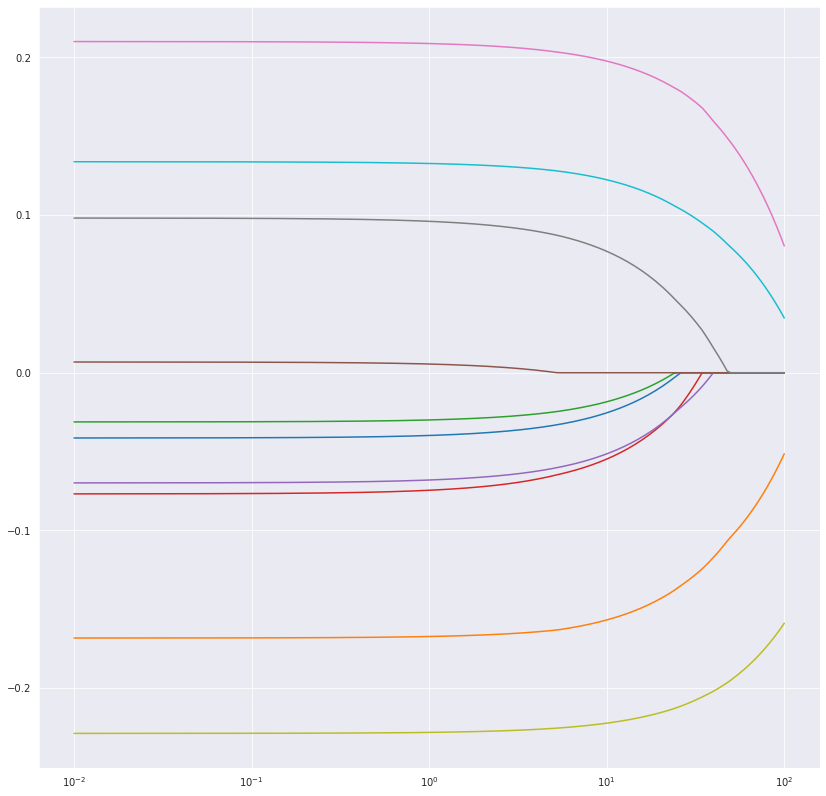

In [129]:
X_tensor, y_tensor, X_np, y_np = synthetic_dataset(n=100, p=10, seed=1)
sigma_regr = .2
alphas_lasso = np.logspace(-2, 2, 200)
beta_sklearn = np.array(
    [Lasso(alpha=alpha, fit_intercept=False).fit(X_np, y_np).coef_ for alpha in
     tqdm.tqdm(alphas_lasso * sigma_regr ** 2 / X_np.shape[0])])
plt.figure(figsize=(14, 14))
plt.plot(alphas_lasso, beta_sklearn)
plt.xscale('log')
plt.show()

In [46]:
device = 'cuda'
set_random_seeds(1234)

dir_name = "./plots/"
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

# load data
X_tensor, y_tensor, X_np, y_np = load_diabetes_dataset(device=device)

# build model
flow_dim = X_tensor.shape[1]
q = 1
flow_params = dict(flow_dim=flow_dim, 
                   q=q, 
                   n_layers=5, 
                   context_features=256, 
                   hidden_features=256, 
                   device=device)

R^2 score: 0.5177
Sigma regression: 0.6944
Norm coefficients: 0.8511


### Train conditional flow with Laplace prior

In [52]:
X_tensor, y_tensor, X_np, y_np = synthetic_dataset(n=100, p=10, seed=1)

R^2 score: 0.8021
Sigma regression: 0.0111


100%|██████████| 200/200 [00:00<00:00, 2046.20it/s]


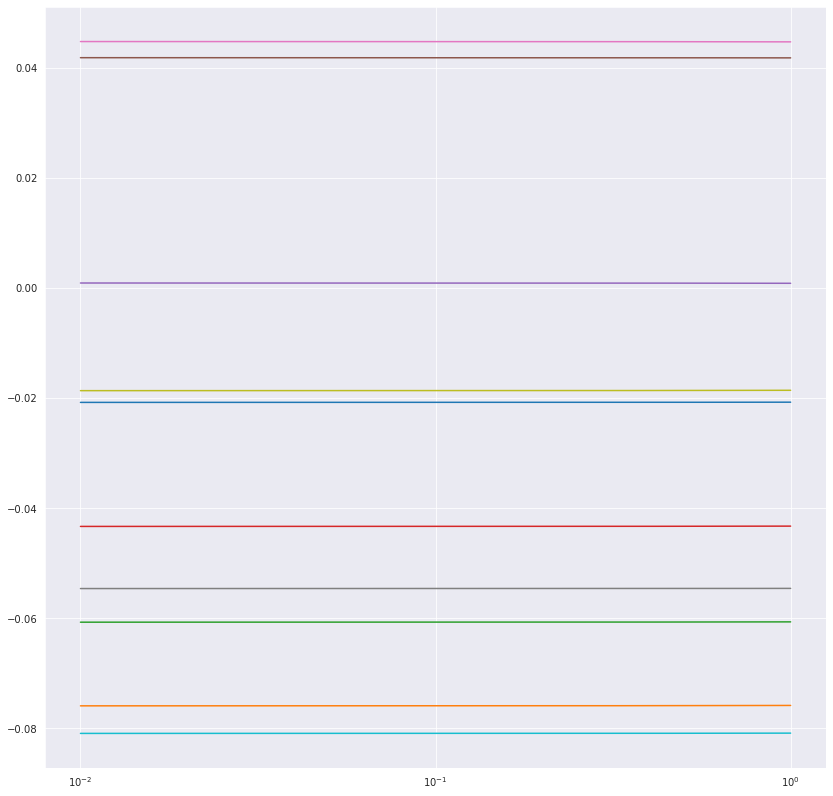

In [53]:
sigma_regr = 0.01
alphas_lasso = np.logspace(-2, 0, 200)
beta_sklearn = np.array(
    [Lasso(alpha=alpha, fit_intercept=False).fit(X_np, y_np).coef_ for alpha in tqdm.tqdm(alphas_lasso * sigma_regr **2 / X_np.shape[0])])
plt.figure(figsize=(14,14))
plt.plot(alphas_lasso, beta_sklearn)
plt.xscale('log')
plt.show()

In [48]:
train_params = dict(q=q,
                  sigma=torch.tensor(.01),
                  lr=1e-3,#,1e-4,
                  epochs=1000,
                  T0=2,
                  Tn=1e-3,
                  iter_per_cool_step=50,
                  lambda_min_exp=-2,#-1,
                  lambda_max_exp=0,#3,
                  sample_size=1,
                  context_size=5000,
                  device=device)

In [23]:
# flow = utils_.build_cond_flow(**flow_params)
# flow.load_state_dict(torch.load("./models/flow_T_1"))

Training loss at step 0: 103954.9 and 51970.7 * (T = 2.000)
Training loss at step 1: 29001.7 and 14498.3 * (T = 2.000)
Training loss at step 2: 2943.3 and 1479.0 * (T = 2.000)
Training loss at step 3: 315.6 and 184.5 * (T = 2.000)
Training loss at step 4: 1903.8 and 1002.4 * (T = 2.000)
Training loss at step 5: 5425.4 and 2781.8 * (T = 2.000)
Training loss at step 6: 1486.4 and 817.0 * (T = 2.000)
Training loss at step 7: 1374.3 and 762.3 * (T = 2.000)
Training loss at step 8: 1138.4 and 639.5 * (T = 2.000)
Training loss at step 9: 1364.4 and 751.5 * (T = 2.000)
Training loss at step 10: 297.0 and 214.9 * (T = 2.000)
Training loss at step 11: 580.8 and 354.4 * (T = 2.000)
Training loss at step 12: 227.6 and 175.2 * (T = 2.000)
Training loss at step 13: 65.4 and 90.2 * (T = 2.000)
Training loss at step 14: 281.8 and 196.3 * (T = 2.000)
Training loss at step 15: 135.2 and 121.3 * (T = 2.000)
Training loss at step 16: -90.0 and 7.0 * (T = 2.000)
Training loss at step 17: -86.7 and 7.3 * (

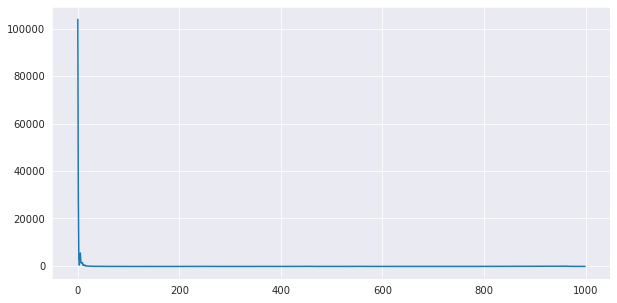

100%|██████████| 1000/1000 [00:00<00:00, 2223.47it/s]


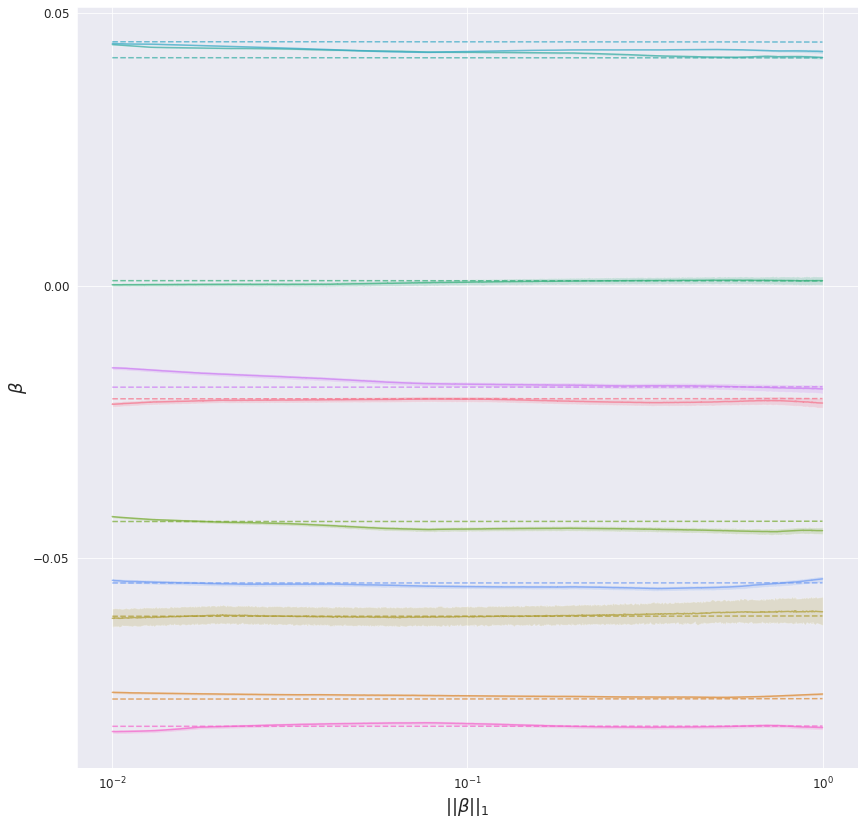

norms: min=0.4 max=0.4
min samples per bin 0


/home/negri0001/Documents/Marcello/cond_flows/manifold_flow/utils_.py:421: RuntimeWarning: Mean of empty slice.
  bin_means = np.array([all_samples[digitized == i][:min_n_per_bin].mean(0) for i in range(1, len(bins))])
/home/negri0001/.local/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


IndexError: cannot do a non-empty take from an empty axes.

In [49]:
act = 'sigmoid'
flow = utils_.build_cond_flow(**flow_params)
flow, loss, loss_T = utils_.train_cond_model(flow, X=X_tensor, y=y_tensor, act=act, **train_params)
# torch.save(flow.state_dict(), "./models/flow_T_1")
flow.eval()
plt.figure(figsize=(10, 5))
plt.plot(range(len(loss)), loss, label='loss')
plt.show()
samples_sorted, lambda_sorted, kl_sorted = utils_.sample_beta_exp(flow, X_tensor, y_tensor, q=train_params['q'], act=act, sigma=train_params['sigma'], lambda_min_exp=train_params['lambda_min_exp'], 
                                                     lambda_max_exp=train_params['lambda_max_exp'], context_size=1, sample_size=1000, n_iter=1000, device='cuda')
bins, samples_norm, bin_l_quant, bin_means, bin_r_quant = utils_.plot_betas_lambda(samples_sorted, lambda_sorted,  X_np, y_np, min_bin=0, max_bin=2, n_bins=51,
                                                                                  sigma=train_params['sigma'], norm=train_params['q'], a=0.95, folder_name=dir_name, n_plots=1)

100%|██████████| 1000/1000 [00:00<00:00, 2051.02it/s]


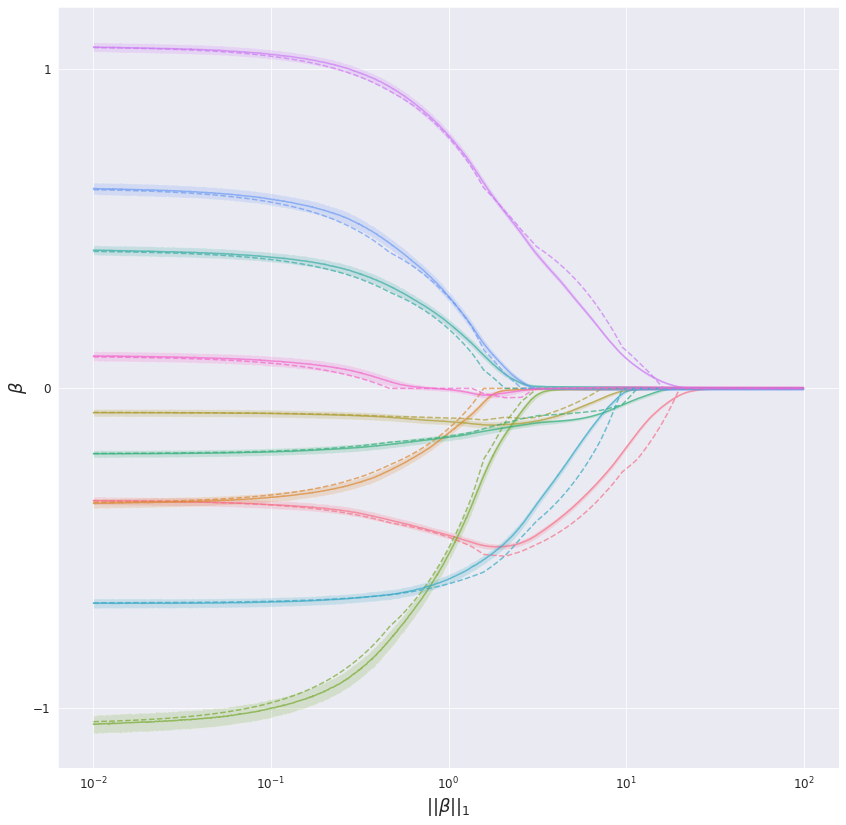

norms: min=0.0 max=5.2
min samples per bin 349


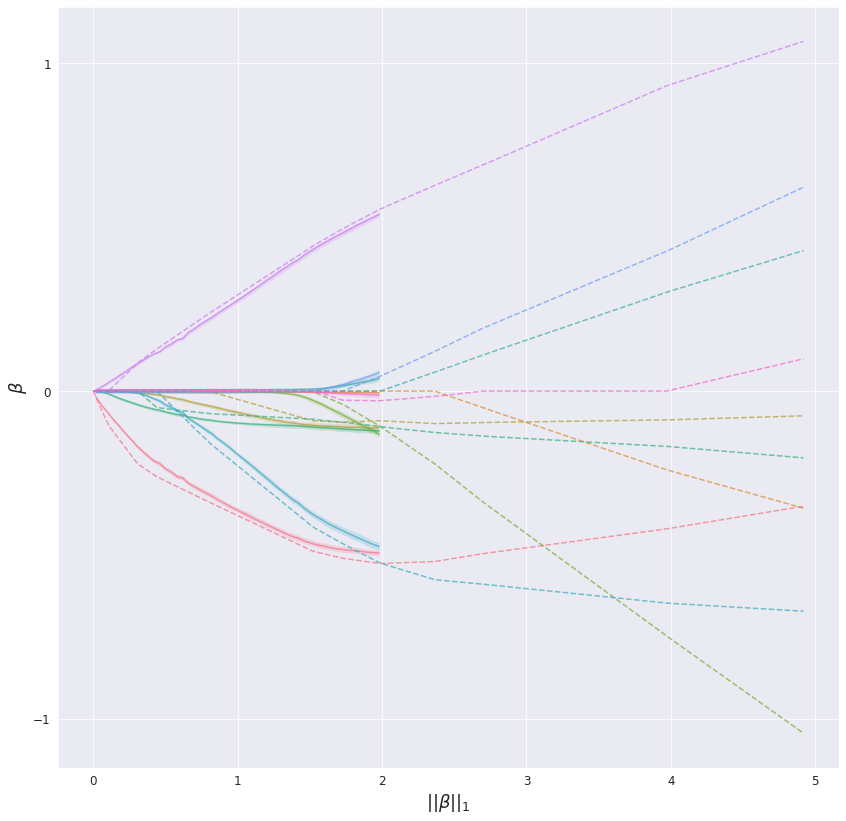

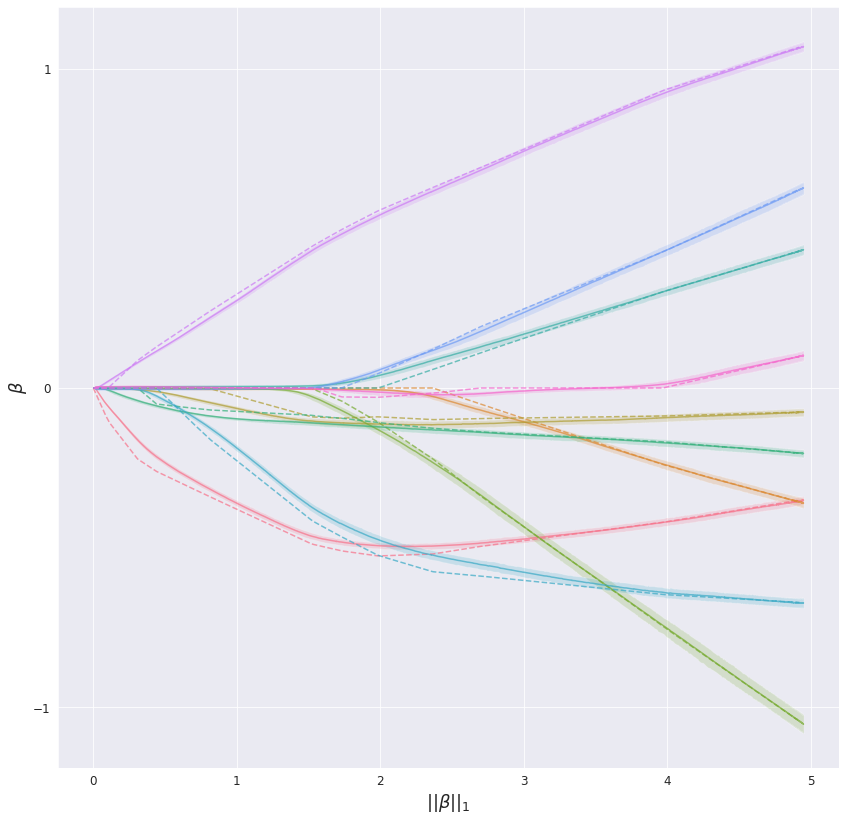

In [122]:
bins, samples_norm, bin_l_quant, bin_means, bin_r_quant = utils_.plot_betas_lambda(samples_sorted, lambda_sorted,  X_np, y_np, min_bin=0, max_bin=2, n_bins=51,
                                                                                  sigma=train_params['sigma'], norm=train_params['q'], a=0.95, folder_name=dir_name, n_plots=1)

In [121]:
from functools import partial
from sklearn.linear_model import lasso_path
import scipy as sp

def mse_lambda(x, samples_mean, lambdas, sigma, n):
    # print()
    beta_sklearn = lasso_path(X_np, y_np, alphas=lambdas * x * sigma**2 / n)[1][:,::-1].T
    # print(beta_sklearn)
    # beta_sklearn = np.array([Lasso(alpha=alpha, fit_intercept=False).fit(X_np, y_np).coef_ for alpha in tqdm.tqdm(lambdas * x * sigma**2 / n)])
    # print(beta_sklearn)
    MSE = np.mean(np.square(samples_mean-beta_sklearn))
    print(MSE)
    return MSE

mse = partial(mse_lambda, samples_mean=samples_sorted.mean(1), lambdas=lambda_sorted, sigma = train_params['sigma'].item(), n=X_np.shape[0])
sp.optimize.minimize(mse, 1, method="Powell")

0.0011588169
0.0011588169
0.011253777


/home/negri0001/anaconda3/envs/cond_flow/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2209255695343018, tolerance: 0.0002712252316996455
  model = cd_fast.enet_coordinate_descent_gram(
/home/negri0001/anaconda3/envs/cond_flow/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2215940952301025, tolerance: 0.0002712252316996455
  model = cd_fast.enet_coordinate_descent_gram(
/home/negri0001/anaconda3/envs/cond_flow/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.221540927886963, tolerance: 0.0002712252316996455
  model = cd_fast.enet_coordinate_descent_gram(
/h

47.802414
0.0011588169
0.006155877
0.004585193
0.00072812045
0.00033733918
0.00028343478
0.00028257526
0.0002817812
0.00028189193
0.0002819115
0.0018848954
0.0002817812
0.008729259


/home/negri0001/anaconda3/envs/cond_flow/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.220231533050537, tolerance: 0.0002712252316996455
  model = cd_fast.enet_coordinate_descent_gram(
/home/negri0001/anaconda3/envs/cond_flow/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2195587158203125, tolerance: 0.0002712252316996455
  model = cd_fast.enet_coordinate_descent_gram(
/home/negri0001/anaconda3/envs/cond_flow/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.21991229057312, tolerance: 0.0002712252316996455
  model = cd_fast.enet_coordinate_descent_gram(
/hom

90.18814
0.0002817812
0.027519694
0.0023468744
0.00061527046
0.0003070111
0.00028202962
0.00028177837
0.00028178343
0.00028177866
0.00028177828
0.00028177843
0.0002817789
0.0002817771
0.00028177787
0.00028178244
0.00028178087


   direc: array([[1.]])
     fun: 0.0002817771
 message: 'Optimization terminated successfully.'
    nfev: 34
     nit: 2
  status: 0
 success: True
       x: array([0.76863063])

opt lambda:  6.7428446 5.191990327835083


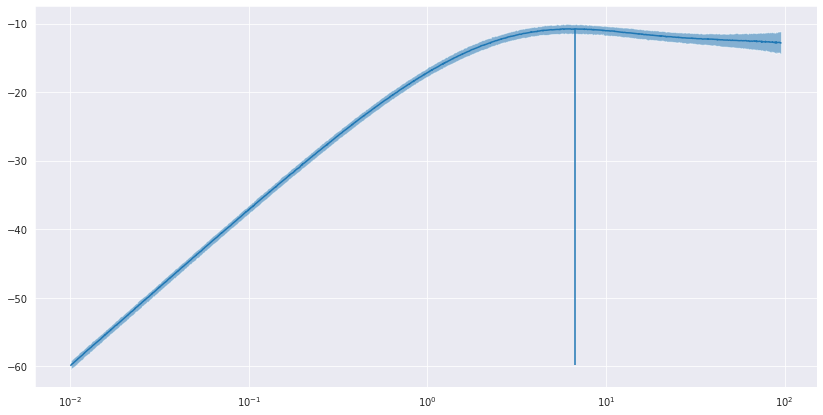

In [10]:
mll = -kl_sorted
mll_mean = mll.mean(1)
mll_l = np.quantile(mll, 0.05, axis=1)
mll_r = np.quantile(mll, 0.95, axis=1)
fig, ax = plt.subplots(figsize=(14,7))
max_mll = np.argmax(mll_mean)
print("opt lambda: ", lambda_sorted[max_mll], lambda_sorted[max_mll]*0.77)
ax.plot(lambda_sorted, mll_mean)
ax.fill_between(lambda_sorted, mll_l, mll_r, alpha=0.5)
plt.vlines(lambda_sorted[max_mll], ymin=mll_mean.min(), ymax=mll_mean.max())
plt.xscale('log')
plt.show()

opt lambda:  6.4796147


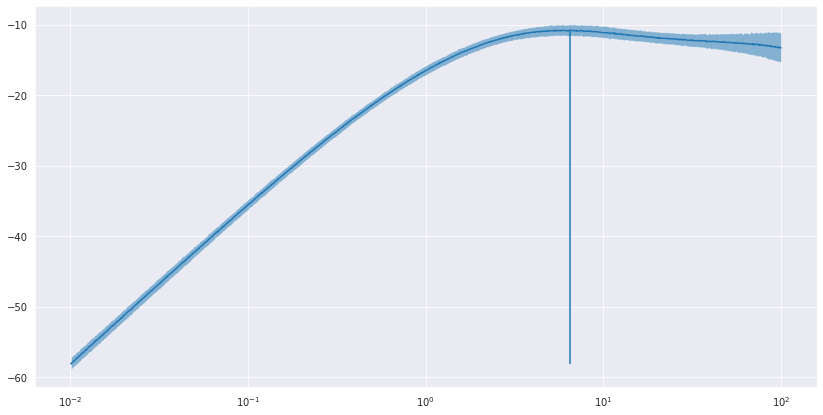

In [12]:
mll = -kl_sorted
mll_mean = mll.mean(1)
mll_l = np.quantile(mll, 0.05, axis=1)
mll_r = np.quantile(mll, 0.95, axis=1)
fig, ax = plt.subplots(figsize=(14,7))
max_mll = np.argmax(mll_mean)
print("opt lambda: ", lambda_sorted[max_mll])
ax.plot(lambda_sorted, mll_mean)
ax.fill_between(lambda_sorted, mll_l, mll_r, alpha=0.5)
plt.vlines(lambda_sorted[max_mll], ymin=mll_mean.min(), ymax=mll_mean.max())
plt.xscale('log')
plt.show()

opt lambda:  8.433688


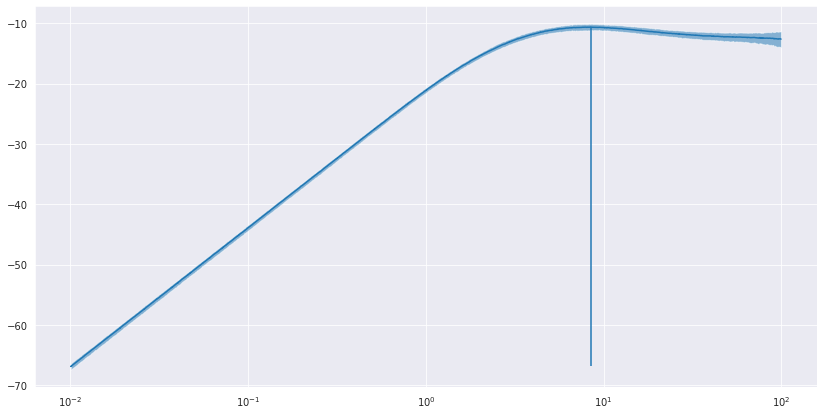

In [46]:
mll = -kl_sorted
mll_mean = mll.mean(1)
mll_l = np.quantile(mll, 0.05, axis=1)
mll_r = np.quantile(mll, 0.95, axis=1)
fig, ax = plt.subplots(figsize=(14,7))
max_mll = np.argmax(mll_mean)
print("opt lambda: ", lambda_sorted[max_mll])
ax.plot(lambda_sorted, mll_mean)
ax.fill_between(lambda_sorted, mll_l, mll_r, alpha=0.5)
plt.vlines(lambda_sorted[max_mll], ymin=mll_mean.min(), ymax=mll_mean.max())
plt.xscale('log')
plt.show()

opt lambda:  9.807806


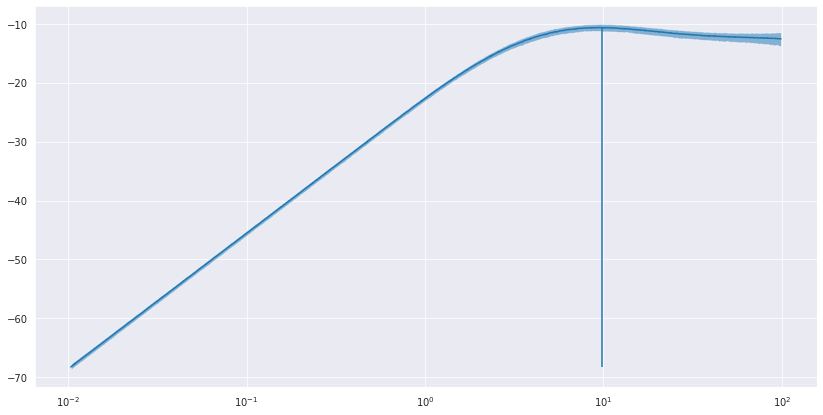

In [48]:
mll = -kl_sorted
mll_mean = mll.mean(1)
mll_l = np.quantile(mll, 0.05, axis=1)
mll_r = np.quantile(mll, 0.95, axis=1)
fig, ax = plt.subplots(figsize=(14,7))
max_mll = np.argmax(mll_mean)
print("opt lambda: ", lambda_sorted[max_mll])
ax.plot(lambda_sorted, mll_mean)
ax.fill_between(lambda_sorted, mll_l, mll_r, alpha=0.5)
plt.vlines(lambda_sorted[max_mll], ymin=mll_mean.min(), ymax=mll_mean.max())
plt.xscale('log')
plt.show()

In [4]:
def laplace(x,l):
    return torch.exp(-l * (x.abs()))

In [86]:
def compute_norm_const(pdf, lambdas, n_points=1_000_000):
    x_mesh = torch.linspace(0, 10, n_points)
    y_mesh = pdf(x_mesh, lambdas)
    integral = torch.trapezoid(y=y_mesh, x=x_mesh, dim=-1) * 2
    
    return 1/integral

In [21]:
n_points = 1_000
n_lambdas = 30
lambdas = torch.logspace(-2,2,n_lambdas).reshape(-1,1)
x_mesh = torch.linspace(0, 10, n_points).repeat(n_lambdas, 1) / lambdas
y_mesh = laplace(x_mesh, lambdas)
torch.trapezoid(y=y_mesh, x=x_mesh, dim=-1) * 2

tensor([1.9999e+02, 1.4557e+02, 1.0596e+02, 7.7130e+01, 5.6142e+01, 4.0866e+01,
        2.9746e+01, 2.1652e+01, 1.5760e+01, 1.1472e+01, 8.3503e+00, 6.0782e+00,
        4.4243e+00, 3.2204e+00, 2.3441e+00, 1.7063e+00, 1.2420e+00, 9.0404e-01,
        6.5804e-01, 4.7899e-01, 3.4865e-01, 2.5378e-01, 1.8473e-01, 1.3446e-01,
        9.7874e-02, 7.1242e-02, 5.1857e-02, 3.7746e-02, 2.7475e-02, 1.9999e-02])

In [22]:
2/lambdas

tensor([[2.0000e+02],
        [1.4558e+02],
        [1.0597e+02],
        [7.7132e+01],
        [5.6144e+01],
        [4.0867e+01],
        [2.9747e+01],
        [2.1653e+01],
        [1.5761e+01],
        [1.1472e+01],
        [8.3506e+00],
        [6.0784e+00],
        [4.4244e+00],
        [3.2205e+00],
        [2.3442e+00],
        [1.7063e+00],
        [1.2420e+00],
        [9.0407e-01],
        [6.5807e-01],
        [4.7901e-01],
        [3.4867e-01],
        [2.5379e-01],
        [1.8473e-01],
        [1.3447e-01],
        [9.7878e-02],
        [7.1245e-02],
        [5.1859e-02],
        [3.7748e-02],
        [2.7476e-02],
        [2.0000e-02]])

In [79]:
x_max = 100
log_integrals , integrals = [], []
n_points = np.logspace(1,7,100).astype('int')
for n in tqdm.tqdm(n_points):
    log_mesh = torch.logspace(-4, 2, n)
    mesh = torch.linspace(0, 100, n)
    log_pdf = laplace(log_mesh, l)
    pdf = laplace(mesh, l)
    log_integral = torch.trapezoid(y=log_pdf, x=log_mesh, dim=-1) * 2
    integral = torch.trapezoid(y=pdf, x=mesh, dim=-1) * 2
    log_integrals.append(log_integral.item())
    integrals.append(integral.item())

100%|██████████| 100/100 [00:00<00:00, 2016.77it/s]


In [80]:
log_integrals[-1], integrals[-1], 2/l.item()

(15.722041130065918, 15.722240447998047, 15.72228782722668)

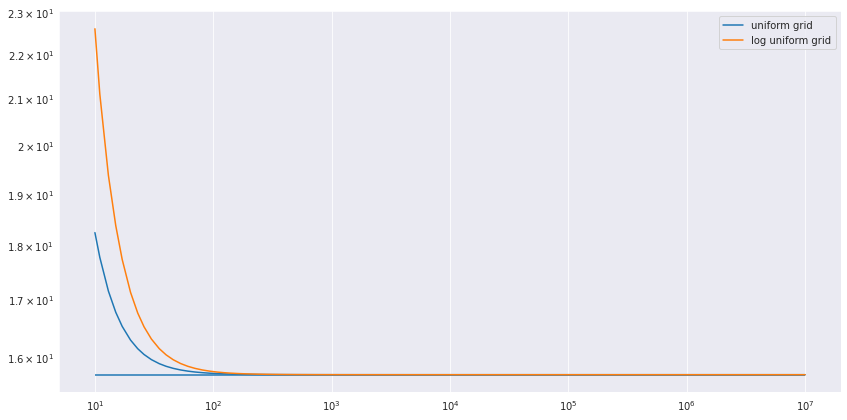

In [81]:
plt.figure(figsize=(14,7))
plt.plot(n_points, integrals, label='uniform grid')
plt.plot(n_points, log_integrals, label='log uniform grid')
plt.hlines(2/l.item(), xmin=n_points[0], xmax=n_points[-1])
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [89]:
monotone_activations = ["tanh_10", "tanh_5", "tanh_1", "tanh_0.5", "tanh_0.1"]
samples = {}
for act in monotone_activations:
    flow = utils_.build_cond_flow(flow_dim, q=q, n_layers=5, context_features=128, hidden_features=256, device=device)
    flow, loss, loss_T = utils_.train_cond_model(flow, X=X_tensor, y=y_tensor, act=act, **train_params)
    # torch.save(flow.state_dict(), "./models/flow_T_1")

IndexError: list index out of range

Training loss at step 0: 260.7 and 41.4 * (T = 5.000)
Training loss at step 1: 235.6 and 36.6 * (T = 5.000)
Training loss at step 2: 214.1 and 32.7 * (T = 5.000)
Training loss at step 3: 192.9 and 28.8 * (T = 5.000)
Training loss at step 4: 178.3 and 26.3 * (T = 5.000)
Training loss at step 5: 156.1 and 22.3 * (T = 5.000)
Training loss at step 6: 146.1 and 20.7 * (T = 5.000)
Training loss at step 7: 125.5 and 17.3 * (T = 5.000)
Training loss at step 8: 106.5 and 14.2 * (T = 5.000)
Training loss at step 9: 96.1 and 12.6 * (T = 5.000)
Training loss at step 10: 81.7 and 10.6 * (T = 5.000)
Training loss at step 11: 72.3 and 9.5 * (T = 5.000)
Training loss at step 12: 63.3 and 8.6 * (T = 5.000)
Training loss at step 13: 56.0 and 7.9 * (T = 5.000)
Training loss at step 14: 47.4 and 7.1 * (T = 5.000)
Training loss at step 15: 40.9 and 6.6 * (T = 5.000)
Training loss at step 16: 36.7 and 6.7 * (T = 5.000)
Training loss at step 17: 32.6 and 6.8 * (T = 5.000)
Training loss at step 18: 31.0 and 7

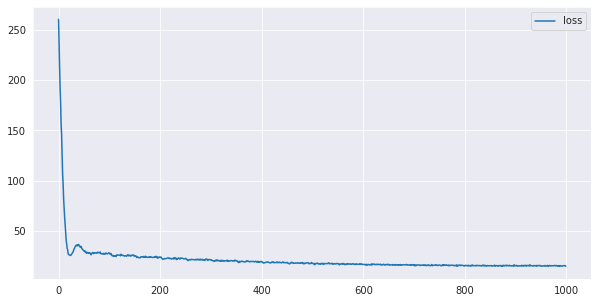

100%|██████████| 1000/1000 [00:00<00:00, 2287.50it/s]


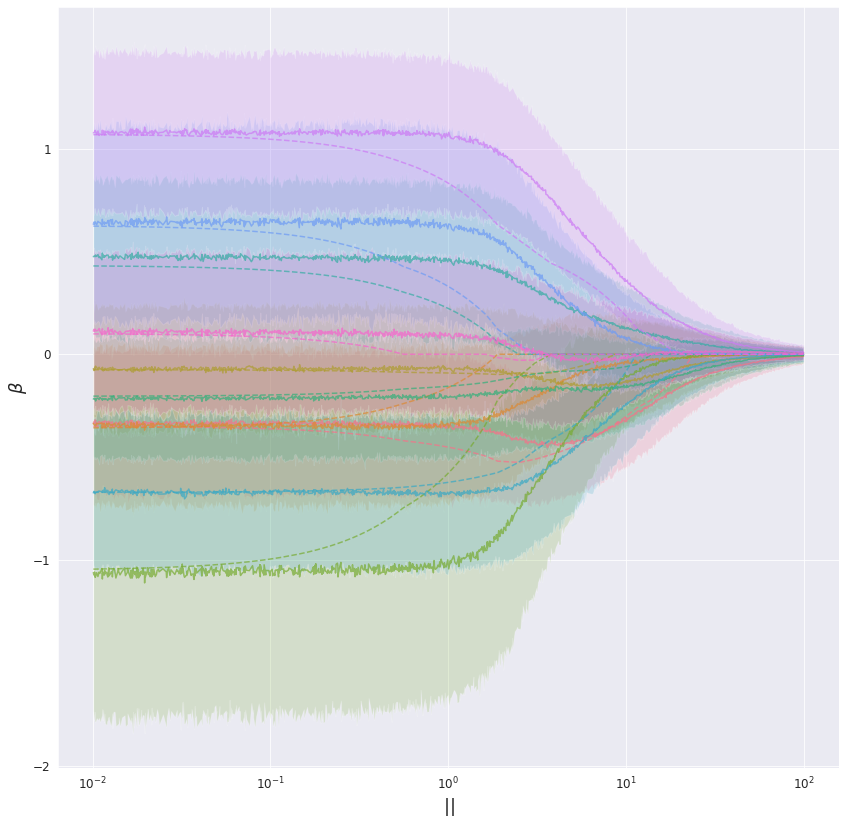

0.055127375 13.050606
min:  205


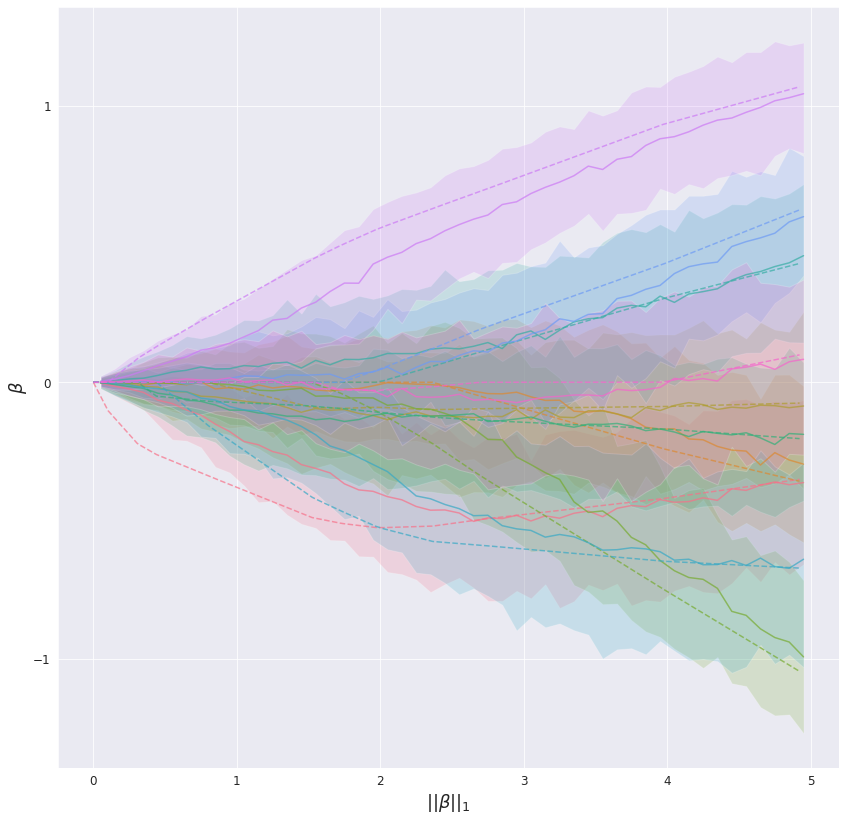

Training loss at step 0: 256.9 and 40.7 * (T = 5.000)
Training loss at step 1: 238.0 and 37.2 * (T = 5.000)
Training loss at step 2: 212.4 and 32.4 * (T = 5.000)
Training loss at step 3: 198.1 and 29.9 * (T = 5.000)
Training loss at step 4: 179.2 and 26.7 * (T = 5.000)
Training loss at step 5: 159.7 and 23.4 * (T = 5.000)
Training loss at step 6: 142.1 and 20.4 * (T = 5.000)
Training loss at step 7: 125.1 and 17.5 * (T = 5.000)
Training loss at step 8: 109.7 and 15.1 * (T = 5.000)
Training loss at step 9: 97.6 and 13.4 * (T = 5.000)
Training loss at step 10: 86.0 and 11.9 * (T = 5.000)
Training loss at step 11: 74.1 and 10.4 * (T = 5.000)
Training loss at step 12: 66.6 and 9.6 * (T = 5.000)
Training loss at step 13: 58.2 and 8.6 * (T = 5.000)
Training loss at step 14: 51.2 and 8.2 * (T = 5.000)
Training loss at step 15: 44.5 and 7.5 * (T = 5.000)
Training loss at step 16: 39.5 and 7.3 * (T = 5.000)
Training loss at step 17: 38.0 and 7.7 * (T = 5.000)
Training loss at step 18: 33.2 and 

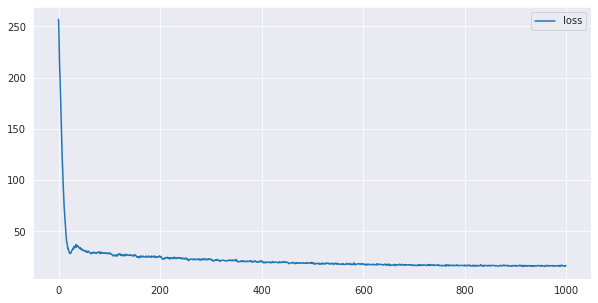

100%|██████████| 1000/1000 [00:00<00:00, 2253.99it/s]


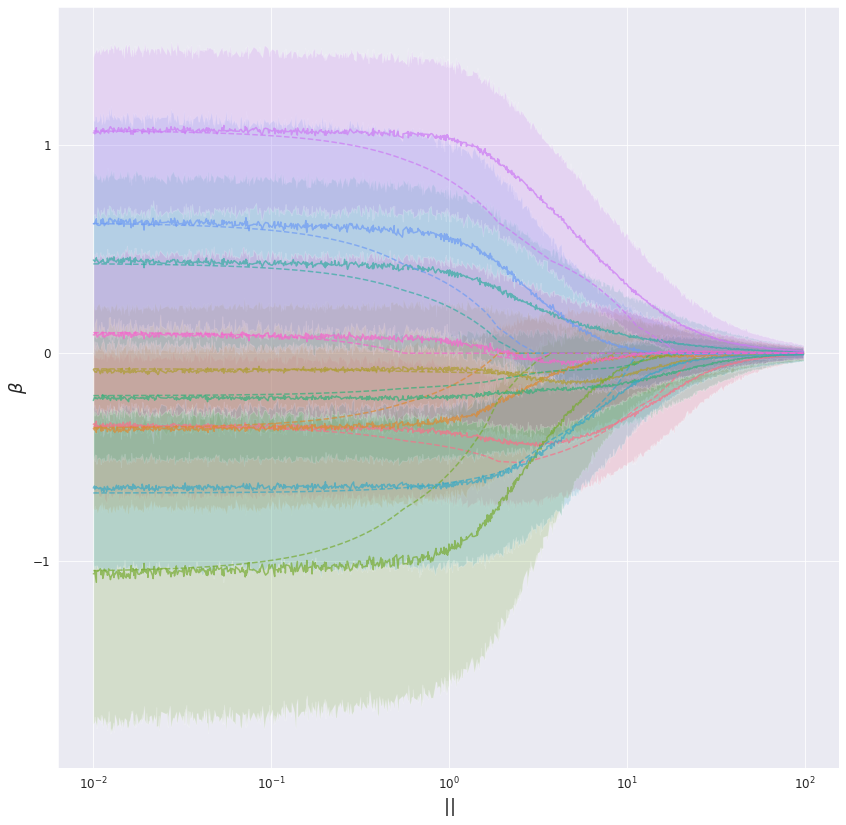

0.041985825 11.519228
min:  1442


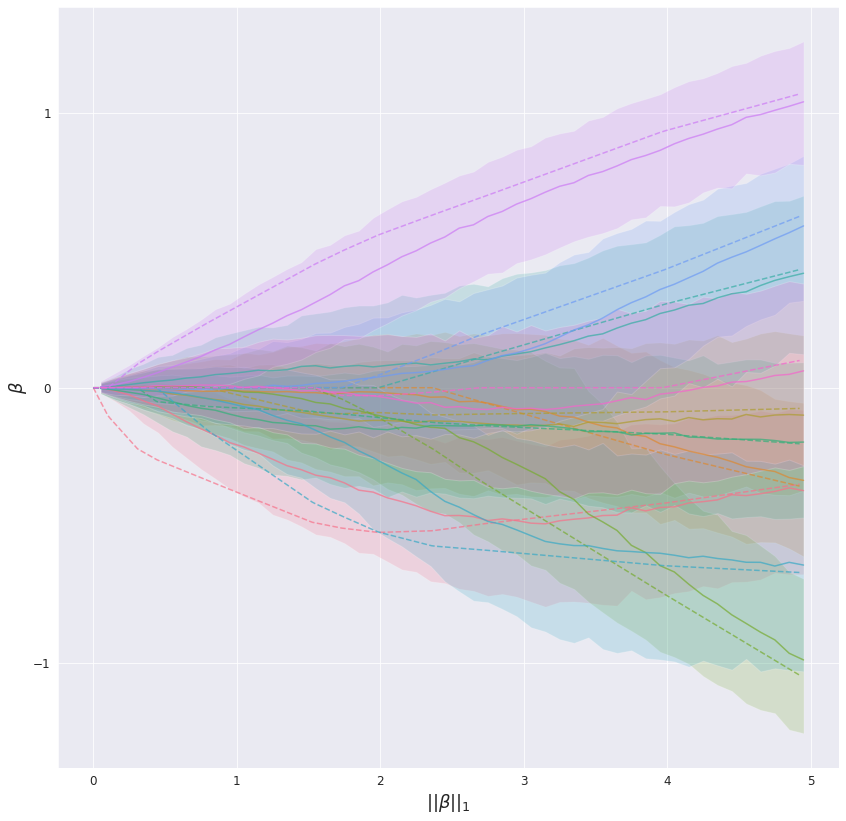

Training loss at step 0: 269.0 and 43.0 * (T = 5.000)
Training loss at step 1: 246.1 and 38.7 * (T = 5.000)
Training loss at step 2: 224.9 and 34.9 * (T = 5.000)
Training loss at step 3: 205.2 and 31.3 * (T = 5.000)
Training loss at step 4: 185.4 and 27.8 * (T = 5.000)
Training loss at step 5: 164.5 and 24.2 * (T = 5.000)
Training loss at step 6: 151.5 and 22.0 * (T = 5.000)
Training loss at step 7: 130.3 and 18.5 * (T = 5.000)
Training loss at step 8: 117.4 and 16.6 * (T = 5.000)
Training loss at step 9: 101.9 and 14.3 * (T = 5.000)
Training loss at step 10: 88.0 and 12.4 * (T = 5.000)
Training loss at step 11: 78.4 and 11.2 * (T = 5.000)
Training loss at step 12: 69.8 and 10.5 * (T = 5.000)
Training loss at step 13: 60.4 and 9.5 * (T = 5.000)
Training loss at step 14: 54.0 and 9.1 * (T = 5.000)
Training loss at step 15: 49.3 and 9.2 * (T = 5.000)
Training loss at step 16: 44.9 and 8.9 * (T = 5.000)
Training loss at step 17: 42.9 and 9.1 * (T = 5.000)
Training loss at step 18: 39.5 an

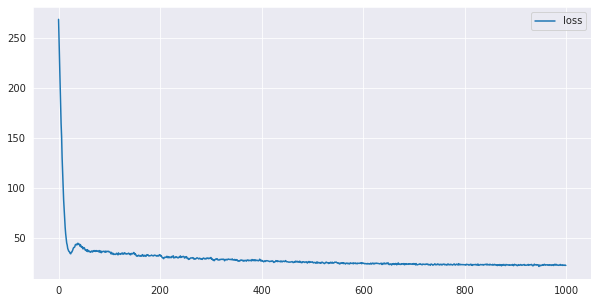

100%|██████████| 1000/1000 [00:00<00:00, 2195.77it/s]


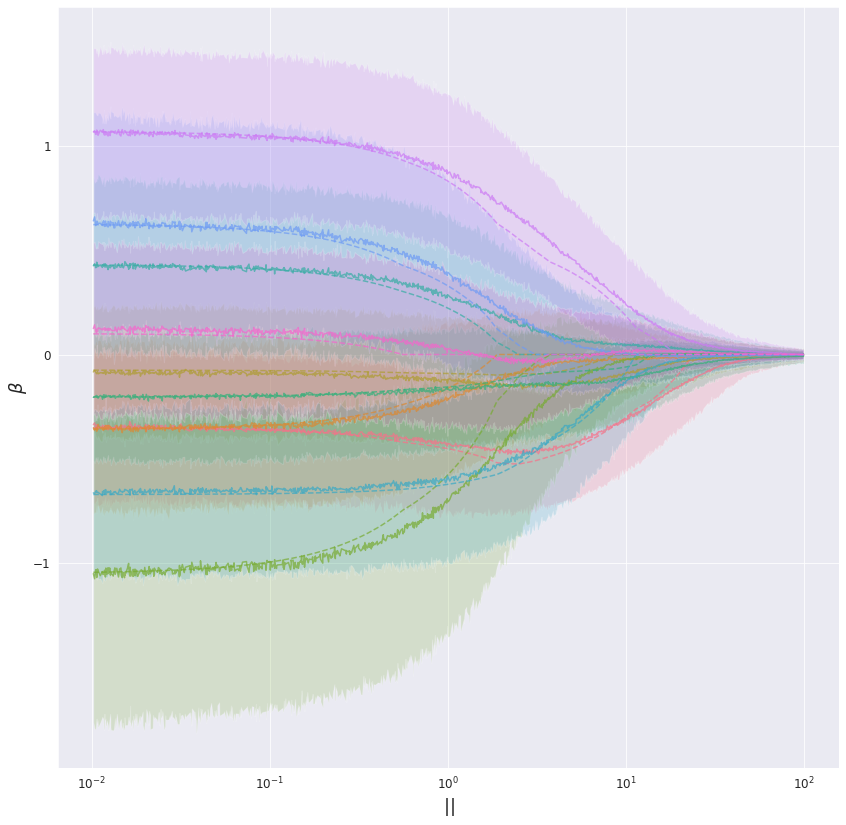

0.021740276 11.997987
min:  8567


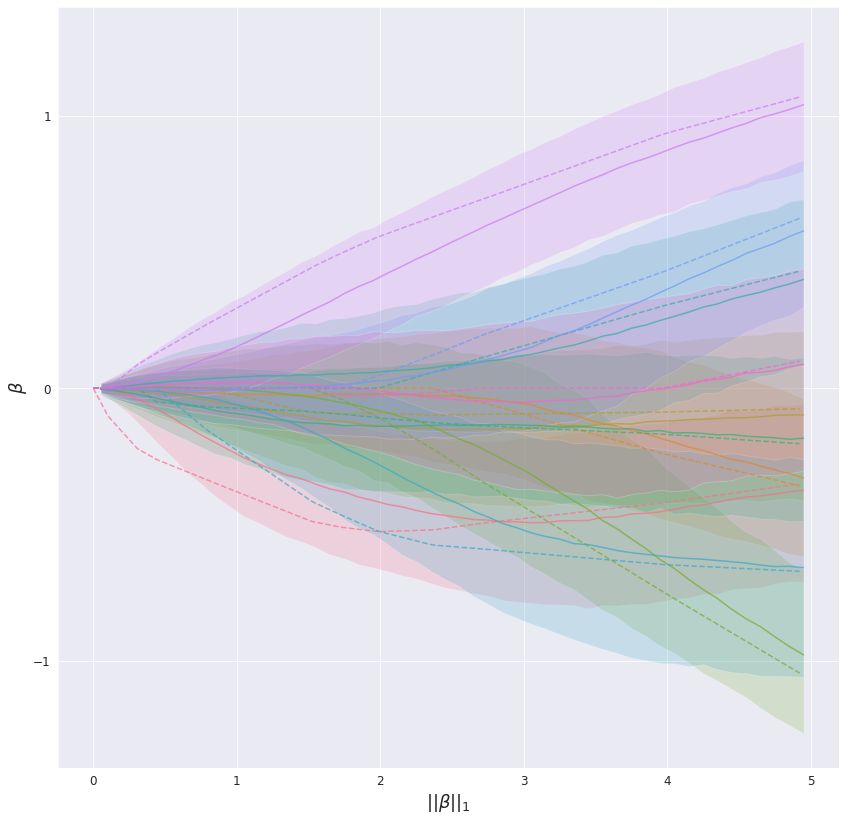

Training loss at step 0: 276.5 and 44.5 * (T = 5.000)
Training loss at step 1: 256.9 and 40.8 * (T = 5.000)
Training loss at step 2: 241.0 and 37.9 * (T = 5.000)
Training loss at step 3: 217.7 and 33.6 * (T = 5.000)
Training loss at step 4: 197.1 and 29.9 * (T = 5.000)
Training loss at step 5: 181.6 and 27.3 * (T = 5.000)
Training loss at step 6: 164.3 and 24.3 * (T = 5.000)
Training loss at step 7: 144.9 and 21.0 * (T = 5.000)
Training loss at step 8: 130.5 and 18.7 * (T = 5.000)
Training loss at step 9: 118.4 and 17.0 * (T = 5.000)
Training loss at step 10: 103.1 and 14.7 * (T = 5.000)
Training loss at step 11: 91.3 and 13.1 * (T = 5.000)
Training loss at step 12: 76.2 and 11.1 * (T = 5.000)
Training loss at step 13: 69.4 and 10.6 * (T = 5.000)
Training loss at step 14: 62.0 and 10.0 * (T = 5.000)
Training loss at step 15: 55.5 and 9.7 * (T = 5.000)
Training loss at step 16: 49.4 and 9.4 * (T = 5.000)
Training loss at step 17: 46.5 and 9.7 * (T = 5.000)
Training loss at step 18: 43.2

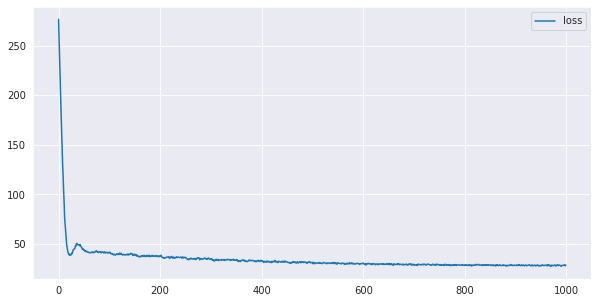

100%|██████████| 1000/1000 [00:00<00:00, 2289.02it/s]


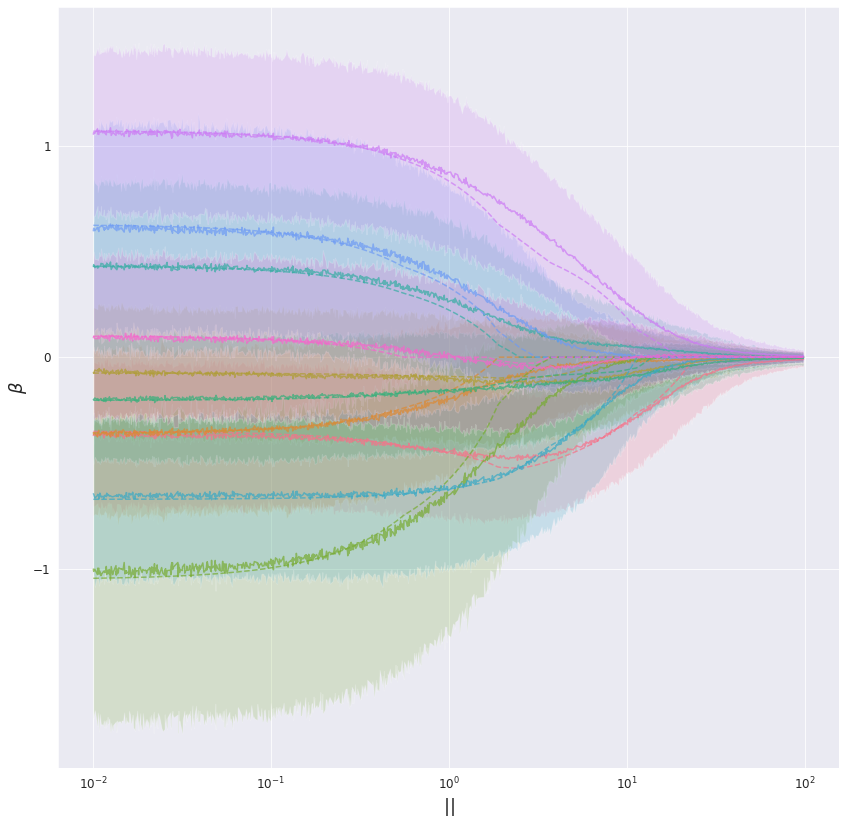

0.018140312 10.260837
min:  8278


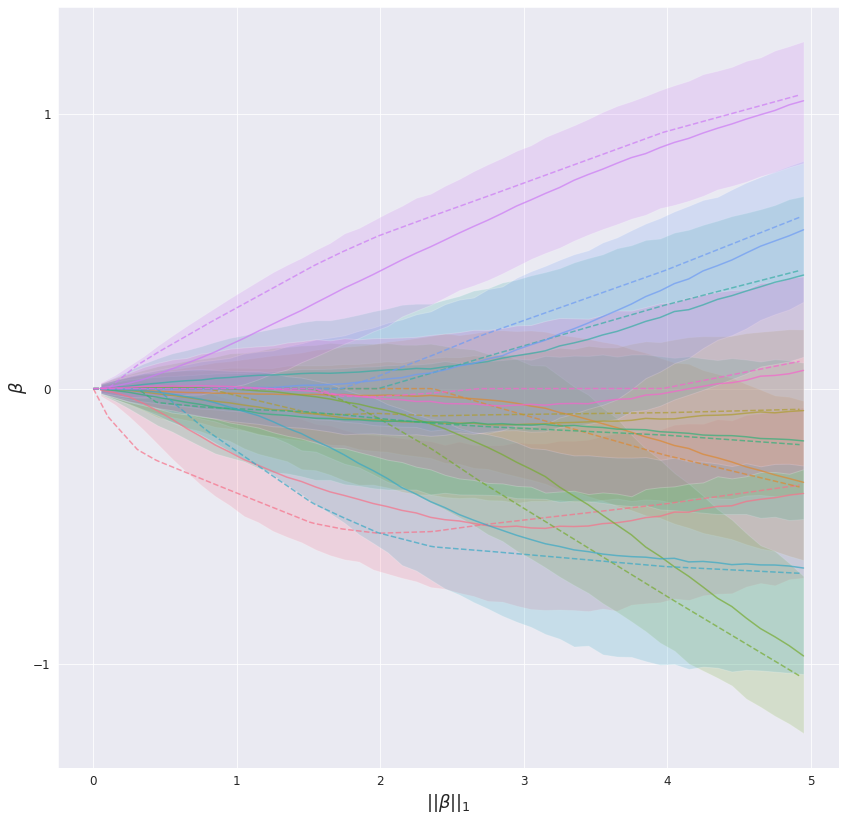

Training loss at step 0: 289.7 and 47.3 * (T = 5.000)
Training loss at step 1: 266.5 and 42.9 * (T = 5.000)
Training loss at step 2: 245.9 and 39.1 * (T = 5.000)
Training loss at step 3: 231.1 and 36.5 * (T = 5.000)
Training loss at step 4: 216.9 and 34.0 * (T = 5.000)
Training loss at step 5: 192.7 and 29.7 * (T = 5.000)
Training loss at step 6: 176.5 and 27.0 * (T = 5.000)
Training loss at step 7: 161.7 and 24.5 * (T = 5.000)
Training loss at step 8: 144.2 and 21.7 * (T = 5.000)
Training loss at step 9: 134.9 and 20.4 * (T = 5.000)
Training loss at step 10: 120.3 and 18.3 * (T = 5.000)
Training loss at step 11: 109.6 and 16.8 * (T = 5.000)
Training loss at step 12: 98.7 and 15.4 * (T = 5.000)
Training loss at step 13: 92.9 and 15.2 * (T = 5.000)
Training loss at step 14: 84.0 and 14.2 * (T = 5.000)
Training loss at step 15: 77.6 and 13.7 * (T = 5.000)
Training loss at step 16: 73.2 and 13.5 * (T = 5.000)
Training loss at step 17: 68.8 and 13.4 * (T = 5.000)
Training loss at step 18: 

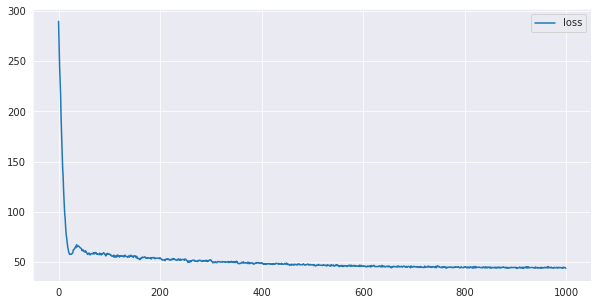

100%|██████████| 1000/1000 [00:00<00:00, 2301.08it/s]


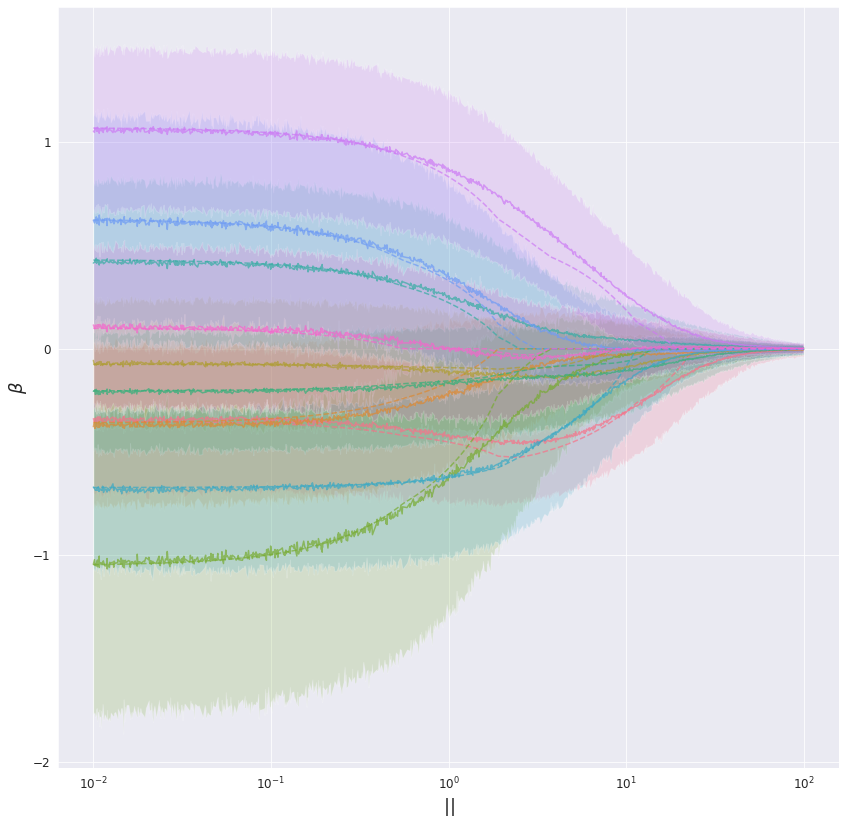

0.022990877 10.713672
min:  8860


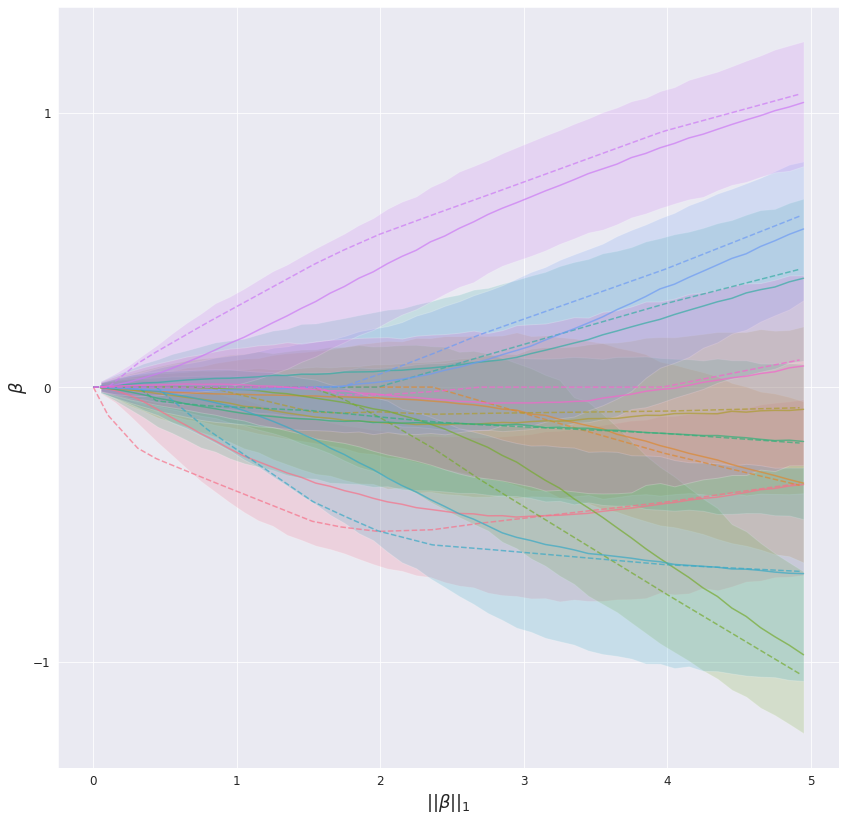

In [152]:
# monotone_activations = ["identity", "sigmoid", "tanh", "softplus"]
monotone_activations = ["identity", "sigmoid", "softplus", "power_4", "power_2", "power_0.5", "power_0.25", "tanh_4", "tanh_1", "tanh_0.25"]
samples = {}
for act in monotone_activations:
    flow = utils_.build_cond_flow(flow_dim, q=q, n_layers=5, context_features=128, hidden_features=256, device=device)
    flow, loss, loss_T = utils_.train_cond_model(flow, X=X_tensor, y=y_tensor, act=act, **params_flow)
    torch.save(flow.state_dict(), "./models/flow_T_1")
    flow.eval()
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(loss)), loss, label='loss')
    plt.show()
    samples_sorted, lambda_sorted, kl_sorted = utils_.sample_beta_exp(flow, X_tensor, y_tensor, sigma=params_flow['sigma'], lambda_min_exp=params_flow['lambda_min_exp'], 
                                                         lambda_max_exp=params_flow['lambda_max_exp'], context_size=1, sample_size=1000, n_iter=1000, device='cuda')
    bins, samples_norm, bin_l_quant, bin_means, bin_r_quant = utils_.plot_betas_lambda(samples_sorted, lambda_sorted,  X_np, y_np, sigma=params_flow['sigma'], norm=params_flow['q'], a=0.95, folder_name=dir_name, n_plots=1)

In [ ]:
for act in monotone_activations:
    flow = utils_.build_cond_flow(**flow_params)
    flow.load_state_dict(torch.load("./models/flow_T_1"))

Training loss at step 0: 60.7 and 31.5 * (T = 2.000)
Training loss at step 1: 44.2 and 23.2 * (T = 2.000)
Training loss at step 2: 33.4 and 18.3 * (T = 2.000)
Training loss at step 3: 27.5 and 16.4 * (T = 2.000)
Training loss at step 4: 24.9 and 15.8 * (T = 2.000)
Training loss at step 5: 24.3 and 15.5 * (T = 2.000)
Training loss at step 6: 24.2 and 15.1 * (T = 2.000)
Training loss at step 7: 24.2 and 14.8 * (T = 2.000)
Training loss at step 8: 24.4 and 14.4 * (T = 2.000)
Training loss at step 9: 24.6 and 14.3 * (T = 2.000)
Training loss at step 10: 24.4 and 14.0 * (T = 2.000)
Training loss at step 11: 23.8 and 13.9 * (T = 2.000)
Training loss at step 12: 22.9 and 13.6 * (T = 2.000)
Training loss at step 13: 22.7 and 13.5 * (T = 2.000)
Training loss at step 14: 22.8 and 13.6 * (T = 2.000)
Training loss at step 15: 22.9 and 13.5 * (T = 2.000)
Training loss at step 16: 23.0 and 13.5 * (T = 2.000)
Training loss at step 17: 23.1 and 13.6 * (T = 2.000)
Training loss at step 18: 23.0 and 13.

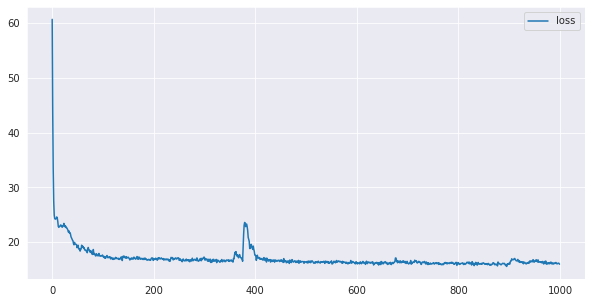

100%|██████████| 2000/2000 [00:00<00:00, 2230.34it/s]


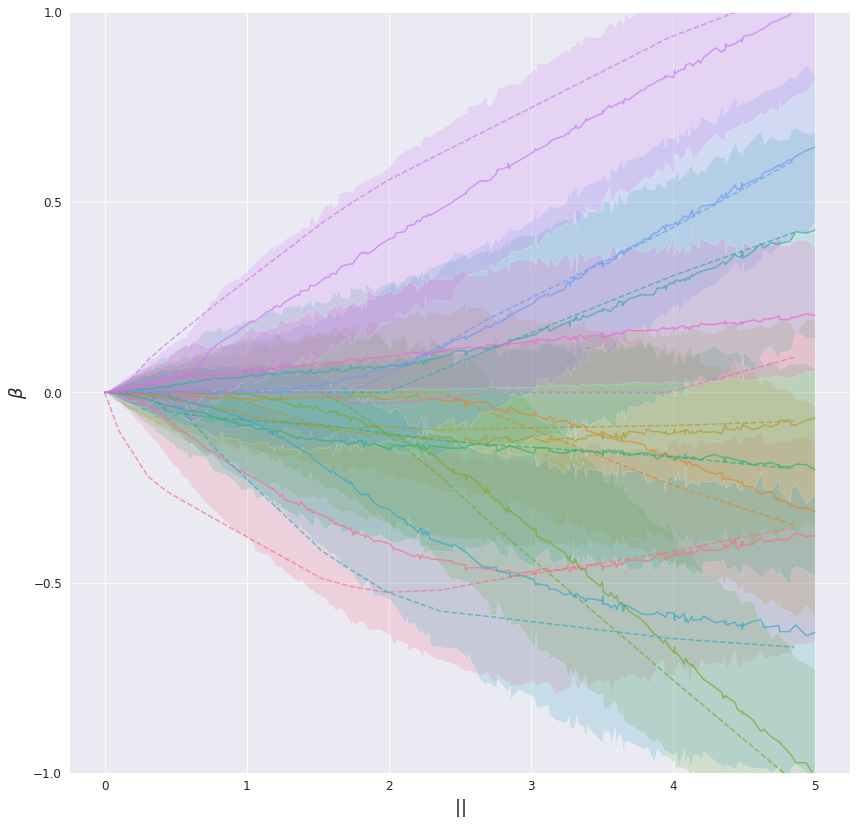

In [106]:
params_flow_manifold = dict(q=q,
                            sigma=torch.tensor(0.2),
                            lr=5e-4,
                            epochs=1000,
                            T0=2,
                            Tn=1,
                            iter_per_cool_step=50,
                            norm_min=0.01,
                            norm_max=5,  #.4
                            sample_size=1,
                            context_size=5000,
                            device=device)

flow_manifold = utils_.build_cond_flow_manifold(flow_dim, q=q, n_layers=5, context_features=128, hidden_features=256,
                                               device=device)
flow_manifold, loss, loss_T = utils_.train_cond_manifold_model(flow_manifold, X=X_tensor, y=y_tensor,
                                                              **params_flow_manifold)
flow_manifold.eval()
plt.figure(figsize=(10, 5))
plt.plot(range(len(loss)), loss, label='loss')
plt.legend()
plt.show()
samples_sorted, norm_sorted, kl_sorted = utils_.sample_beta(flow_manifold, X_tensor, y_tensor,
                                                           sigma=params_flow_manifold['sigma'],
                                                           norm_min=params_flow_manifold['norm_min'],
                                                           norm_max=params_flow_manifold['norm_max'], context_size=1,
                                                           sample_size=1000, n_iter=200, device='cuda')
utils_.plot_betas_norm(samples_sorted, norm_sorted, X_np, y_np, norm=params_flow_manifold['q'], a=0.95, folder_name=dir_name, n_plots=1)

In [160]:
# sample from NF on manifold
indeces = np.linspace(0,49,50).astype('int')[::4]
bins_midpoints = 0.5 * (bins[1:] + bins[:-1])
min_samples = min([samples[act].shape[1] for act in monotone_activations])
# min_samples = 100
norms_flow_torch = torch.from_numpy(bins_midpoints).to(device).to(torch.float32).view(-1,1)
manifold_samples = []
for i in tqdm.tqdm(range(10)):
    flow_manifold_samples, log_probs_samples = flow_manifold.sample_and_log_prob(min_samples//10, context=norms_flow_torch)
    manifold_samples.append(flow_manifold_samples.detach().cpu().numpy())
    del flow_manifold_samples, log_probs_samples
    torch.cuda.empty_cache()
flow_manifold_samples = np.concatenate(manifold_samples, 1)
torch.cuda.empty_cache()
flow_manifold_samples.shape

100%|██████████| 10/10 [00:00<00:00, 14.84it/s]


(50, 200, 10)

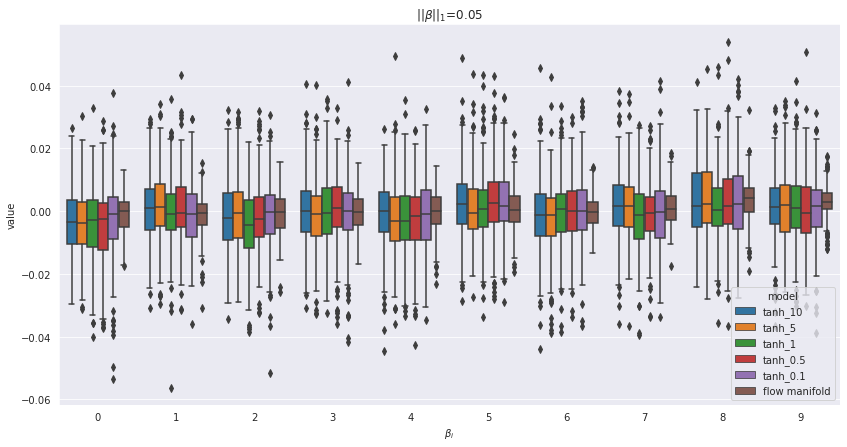

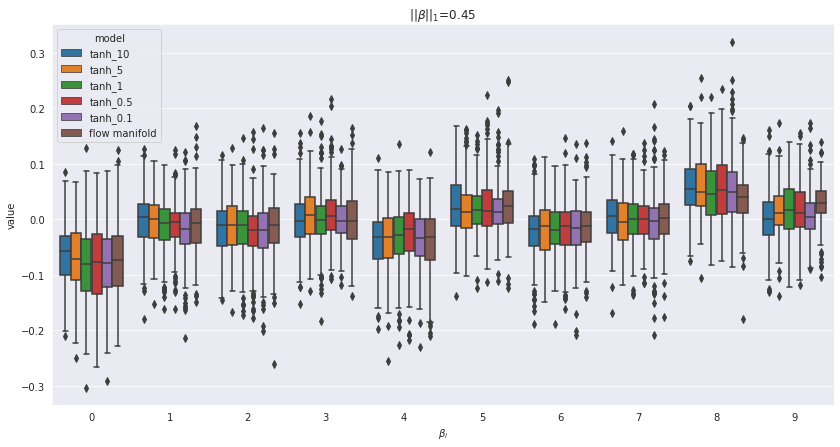

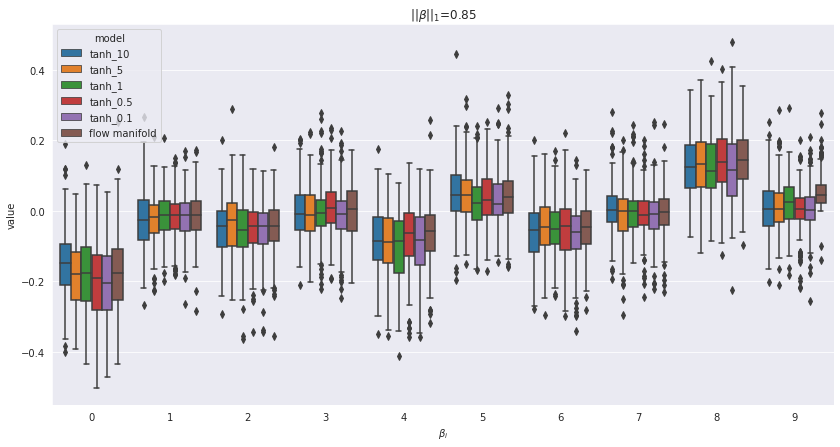

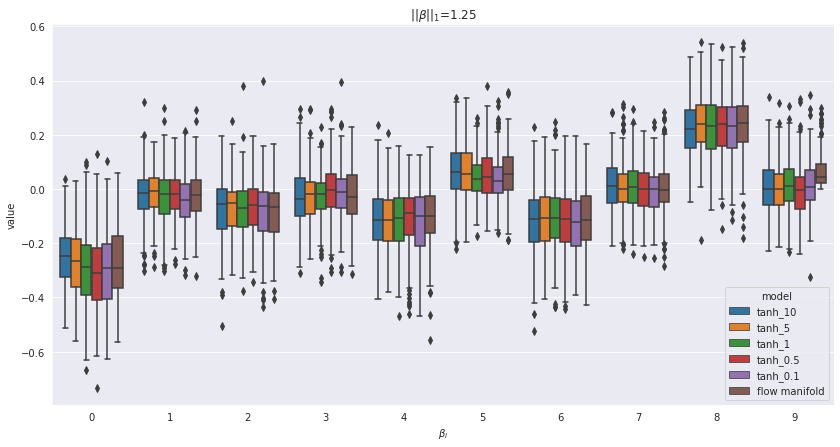

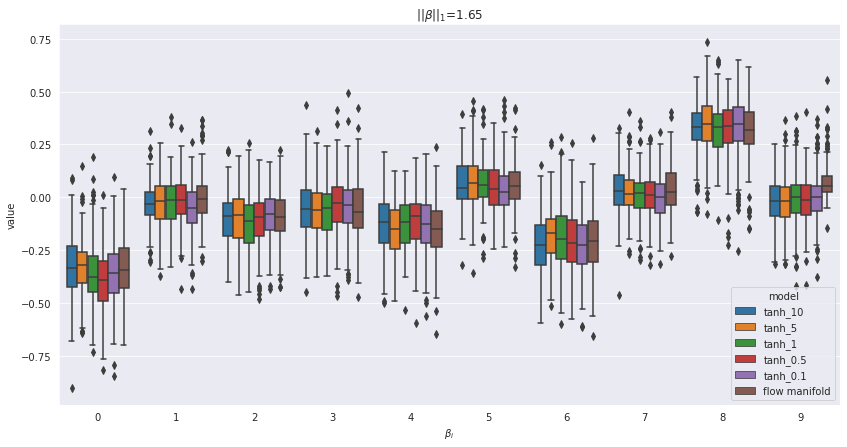

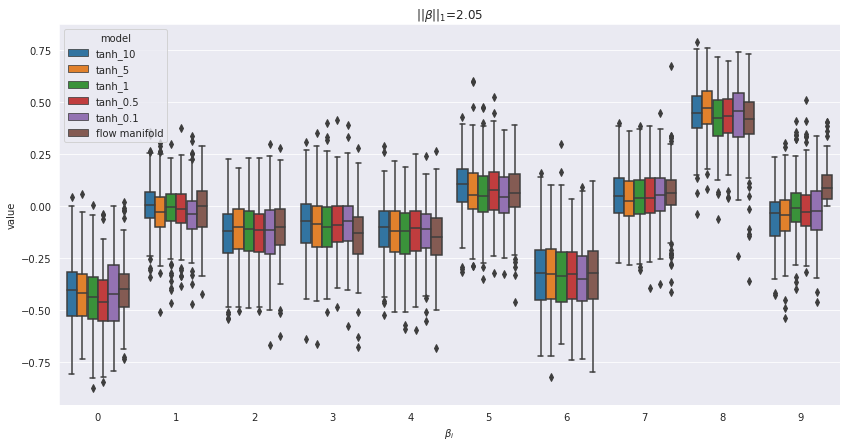

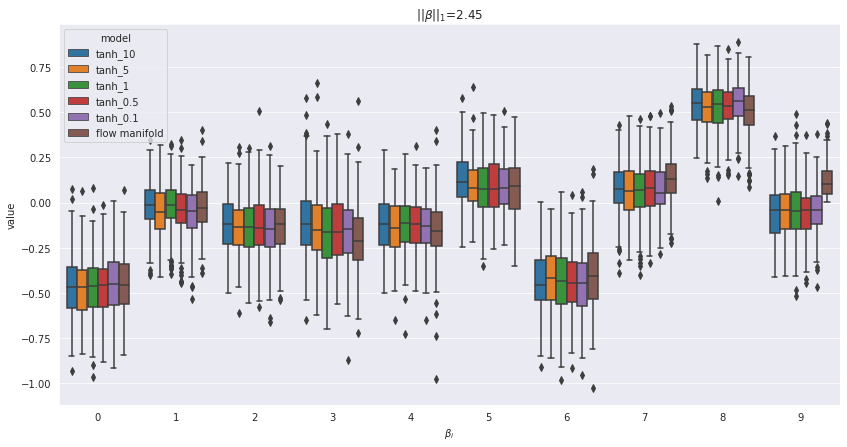

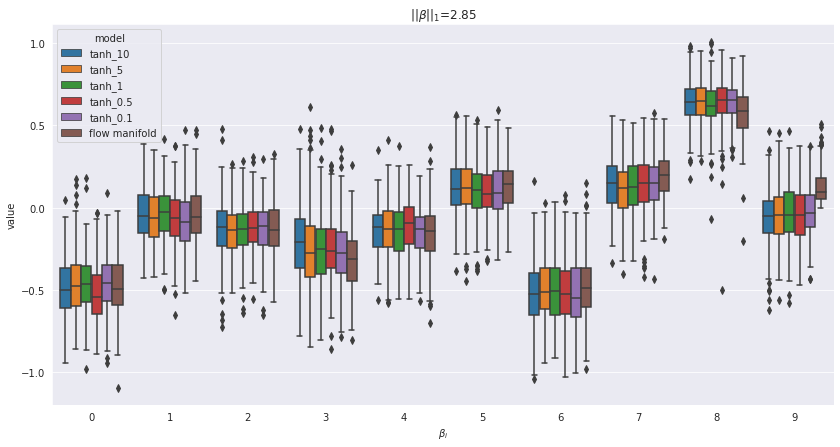

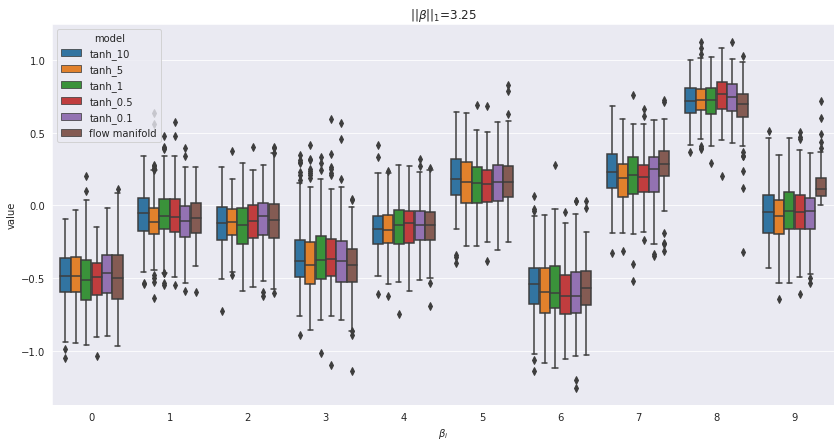

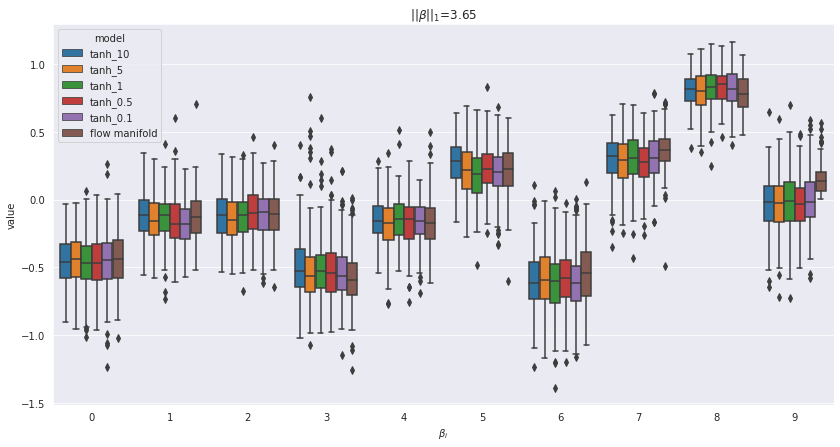

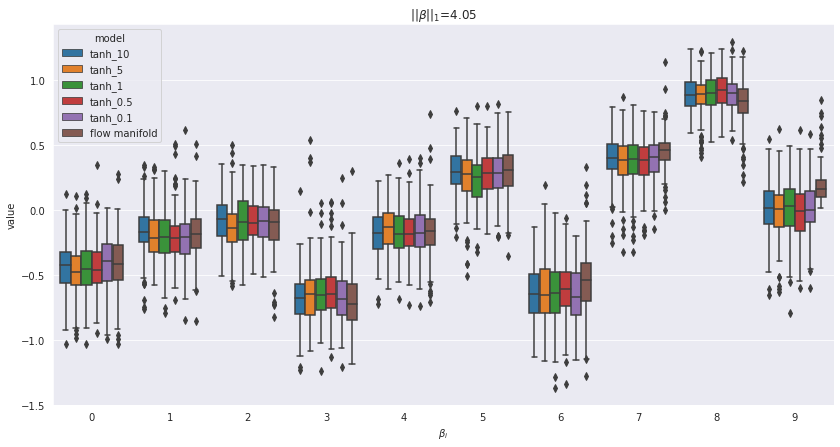

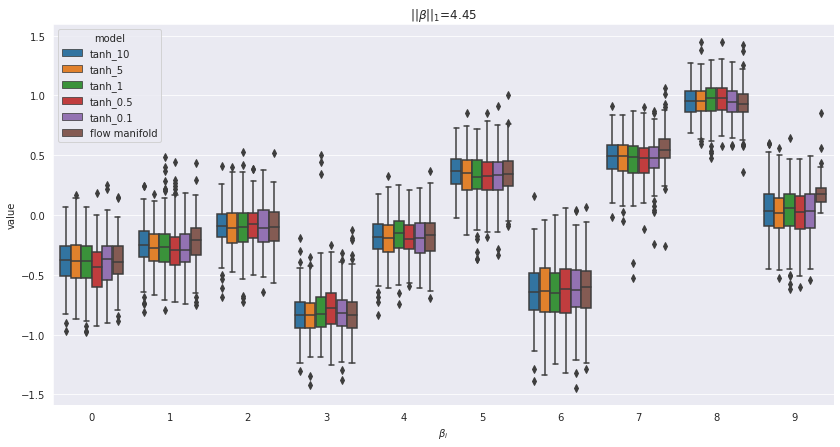

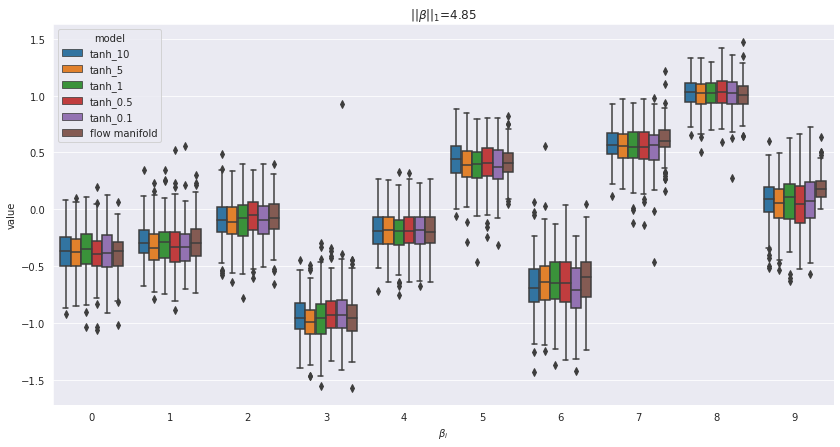

In [161]:
# plot comparison
for i in indeces:
    plt.figure(figsize=(14,7))
    data_frames = [pd.DataFrame(samples[act][i,:min_samples]).assign(model=act) for act in monotone_activations]
    data_frames.append(pd.DataFrame(flow_manifold_samples[i]).assign(model='flow manifold'))
    cdf = pd.concat(data_frames)
    mdf = pd.melt(cdf, id_vars=['model'], var_name=r'$\beta_i$', value_name="value")
    sns.boxplot(x=r'$\beta_i$', y="value", hue="model", data=mdf, showfliers = True)
    # sns.violinplot(x=r'$\beta_i$', y="value", hue="model", data=mdf)
    plt.title(r"$||\beta||_1$={:.2f}".format(bins_midpoints[i]))
    # plt.ylim(-3,3)
    plt.savefig(f"./plots/box_plot_norm_{bins_midpoints[i]:.2f}.pdf")
    plt.show()

In [13]:
samples_sorted, lambda_sorted, kl_sorted = utils_.sample_beta_exp(flow, X_tensor, y_tensor, sigma=params_flow['sigma'], lambda_min_exp=params_flow['lambda_min_exp'], 
                                                     lambda_max_exp=params_flow['lambda_max_exp'], context_size=1, sample_size=100, n_iter=1000, device='cuda')

100%|██████████| 1000/1000 [00:12<00:00, 82.89it/s]


100%|██████████| 1000/1000 [00:01<00:00, 983.05it/s]


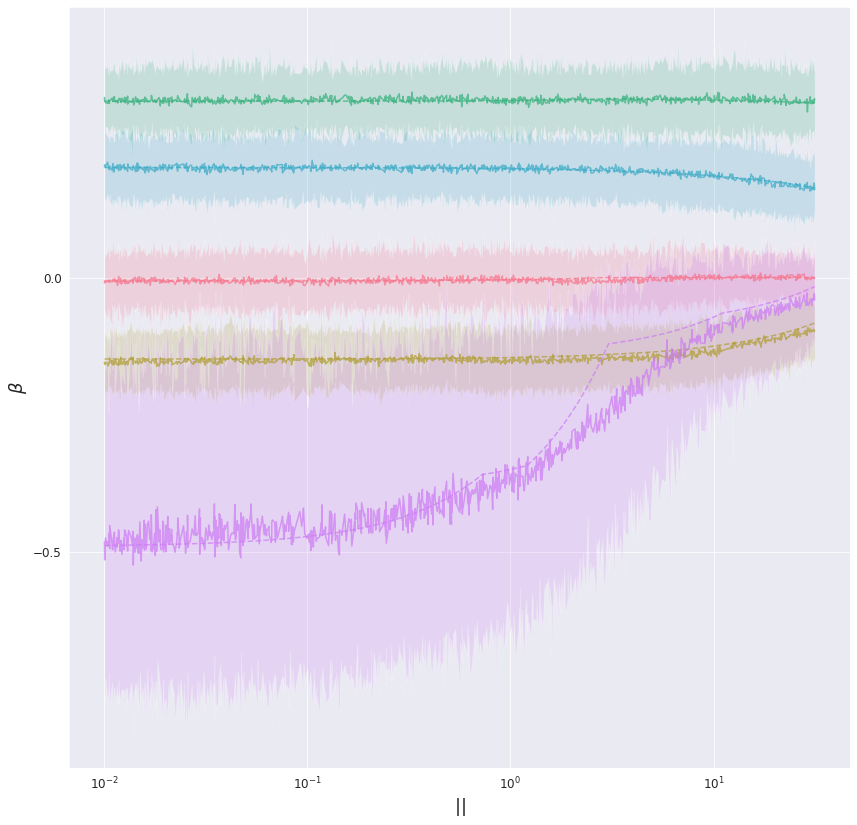

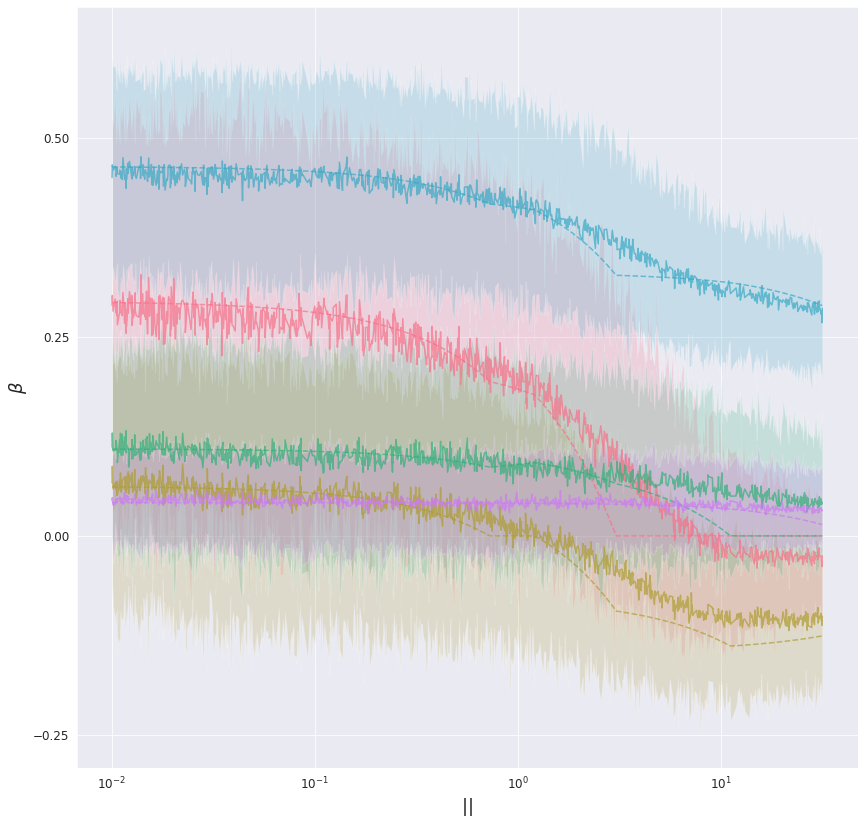

0.84558576 3.9158025
[  17   67  199  444  940 1516 2143 2500 3246 3675 4009 3936 3819 3592
 3247 2951 2758 2598 2591 2591 2510 2525 2520 2536 2550 2481 2365 2336
 2271 2179 2129 2073 2041 1938 1874 1843 1702 1752 1576 1456 1379 1232
 1162 1044  950  851  748  659  565  447]


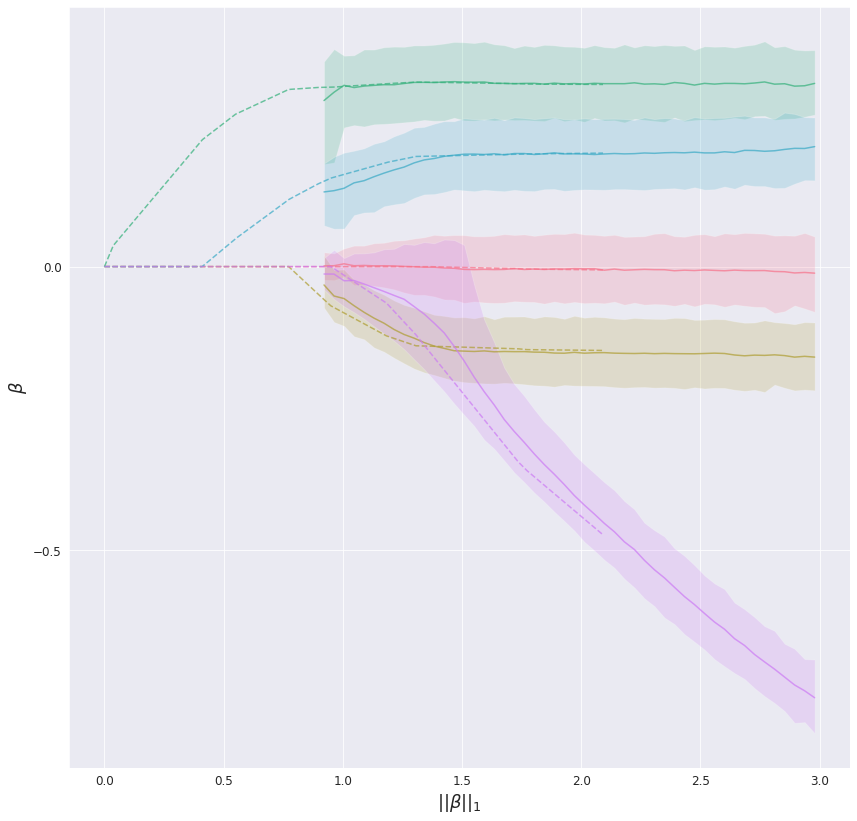

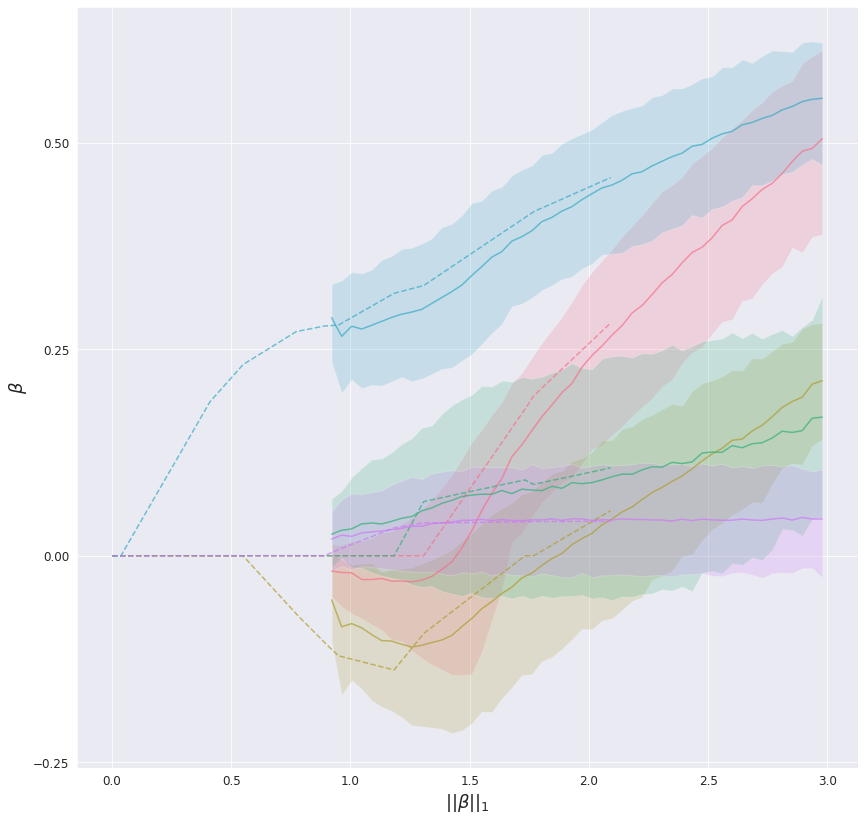

/home/negri0001/Documents/Marcello/cond_flows/manifold_flow/utils.py:437: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  samples_norm = np.array([all_samples[digitized == i][:min_n_per_bin] for i in range(1, len(bins))])


In [14]:
bins, samples_flow, l_flow, means_flow, r_flow = utils_.plot_betas_lambda(samples_sorted, lambda_sorted,  X_np, y_np, sigma=params_flow['sigma'], norm=params_flow['q'], a=0.95, folder_name=dir_name, n_plots=2)

100%|██████████| 1000/1000 [00:01<00:00, 950.46it/s]


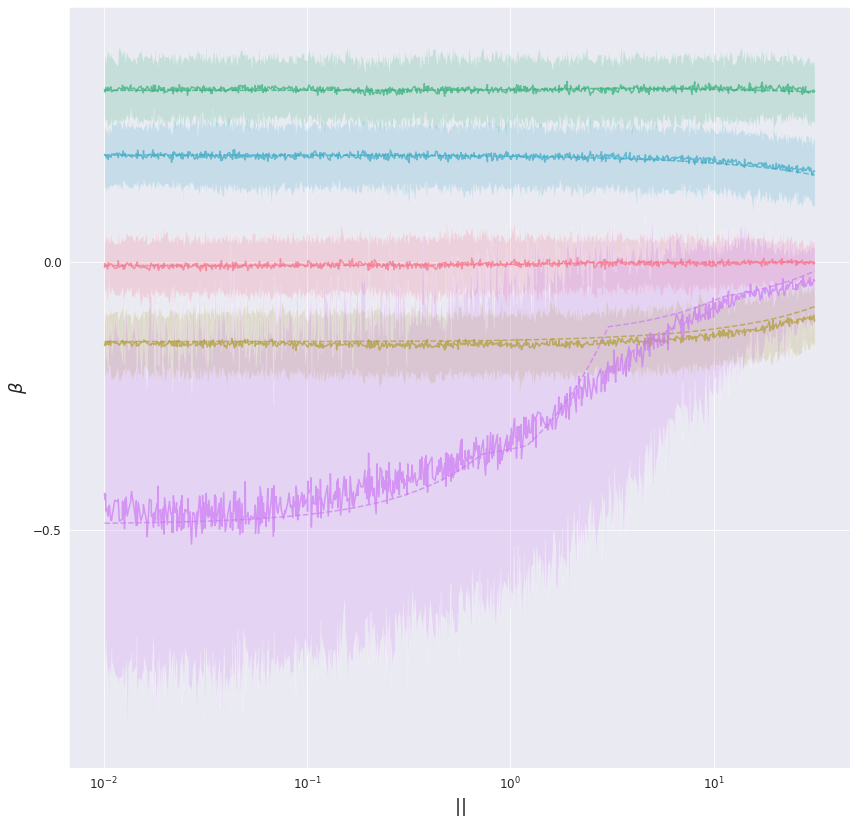

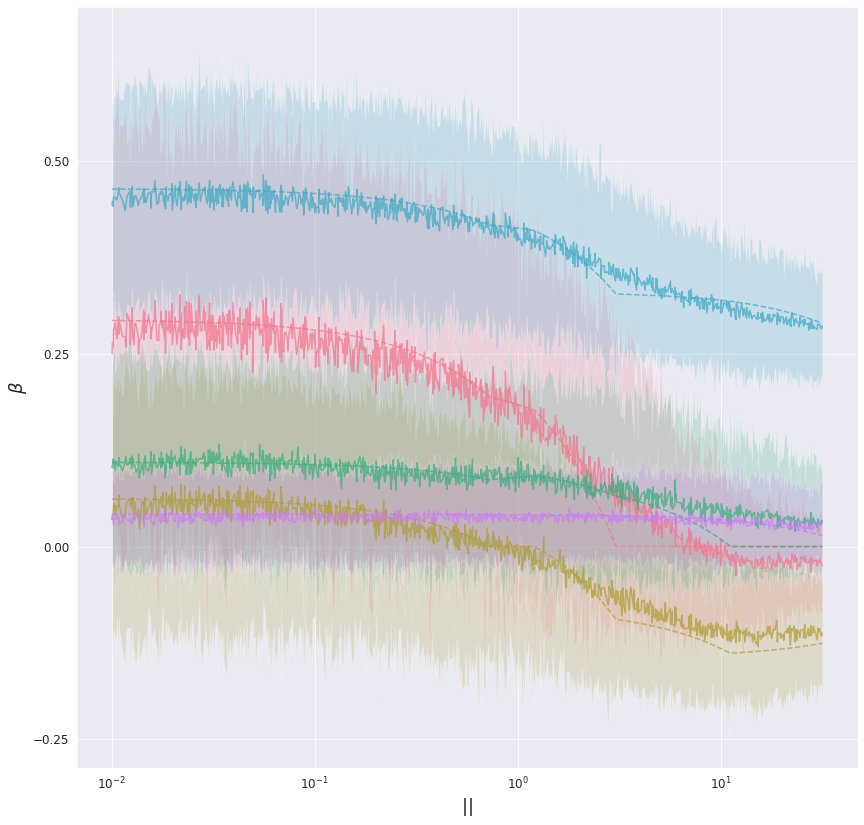

0.8750736 4.683648
[   7   55  169  392  862 1409 2260 2921 3501 4131 4212 4181 4143 3738
 3376 3145 2766 2712 2760 2528 2495 2484 2428 2451 2349 2275 2335 2291
 2200 2178 2100 2086 1983 1938 1788 1755 1680 1564 1487 1348 1260 1088
  952  910  789  725  606  524  416  375]


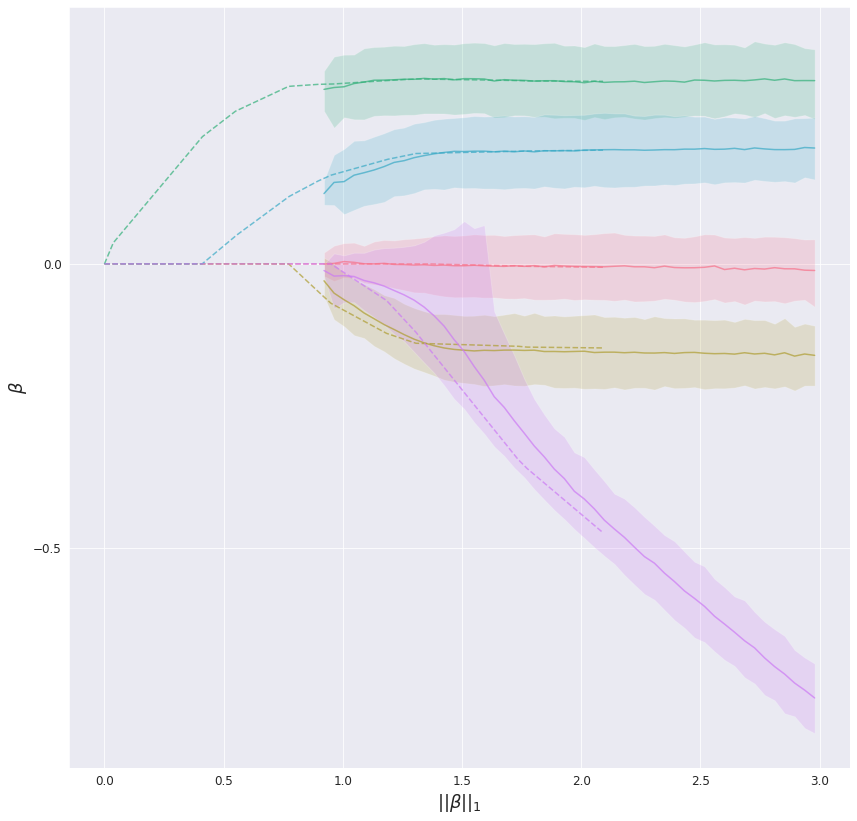

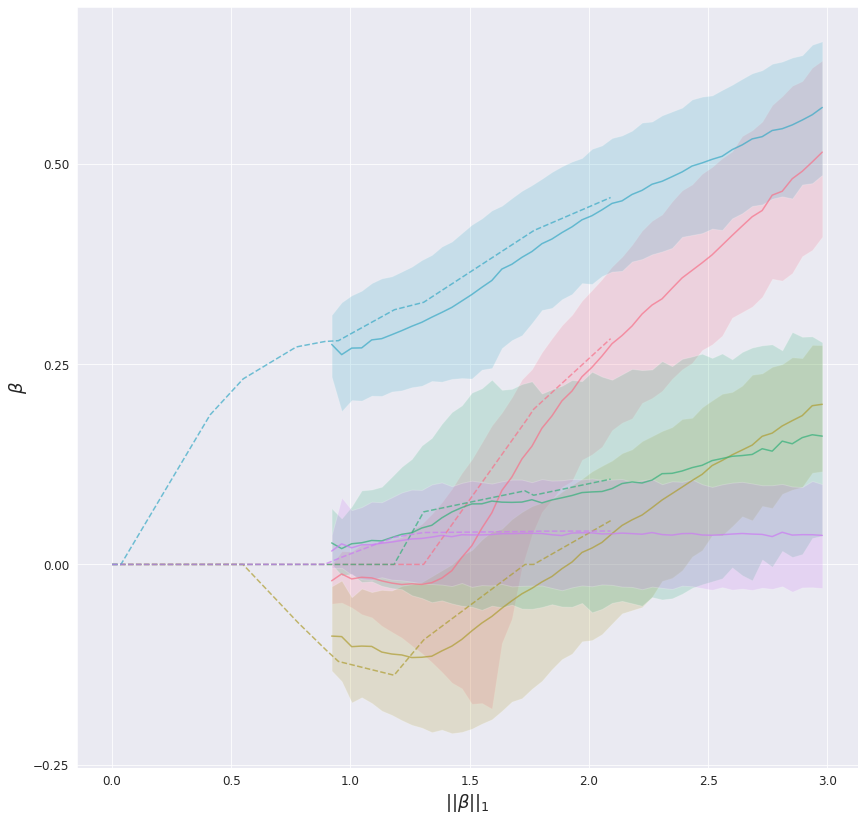

/home/negri0001/Documents/Marcello/cond_flows/manifold_flow/utils.py:437: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  samples_norm = np.array([all_samples[digitized == i][:min_n_per_bin] for i in range(1, len(bins))])


In [10]:
bins, samples_flow, l_flow, means_flow, r_flow = utils_.plot_betas_lambda(samples_sorted, lambda_sorted,  X_np, y_np, sigma=params_flow['sigma'], norm=params_flow['q'], a=0.95, folder_name=dir_name, n_plots=2)

### Sample from Bayes Lasso

In [16]:
data_df = pd.DataFrame(np.c_[y_np,X_np], 
                       columns = ['target','0','1','2','3','4','5','6','7','8','9'])

Training loss at step 0: 6046.3 and 592.6 * (T = 10.000)
Training loss at step 1: 5570.4 and 545.3 * (T = 10.000)
Training loss at step 2: 4857.2 and 474.6 * (T = 10.000)
Training loss at step 3: 4593.4 and 448.7 * (T = 10.000)
Training loss at step 4: 4163.4 and 406.2 * (T = 10.000)
Training loss at step 5: 3656.8 and 356.3 * (T = 10.000)
Training loss at step 6: 3352.9 and 326.4 * (T = 10.000)
Training loss at step 7: 2899.0 and 281.8 * (T = 10.000)
Training loss at step 8: 2498.9 and 242.8 * (T = 10.000)
Training loss at step 9: 2300.4 and 223.9 * (T = 10.000)
Training loss at step 10: 2105.1 and 205.1 * (T = 10.000)
Training loss at step 11: 1858.4 and 181.5 * (T = 10.000)
Training loss at step 12: 1676.5 and 164.4 * (T = 10.000)
Training loss at step 13: 1509.8 and 149.0 * (T = 10.000)
Training loss at step 14: 1368.5 and 136.1 * (T = 10.000)
Training loss at step 15: 1172.7 and 118.6 * (T = 10.000)
Training loss at step 16: 1092.5 and 112.1 * (T = 10.000)
Training loss at step 17

100%|██████████| 1000/1000 [00:11<00:00, 84.05it/s]


Training loss at step 0: 6699.5 and 658.0 * (T = 10.000)
Training loss at step 1: 5932.9 and 581.8 * (T = 10.000)
Training loss at step 2: 5368.3 and 525.7 * (T = 10.000)
Training loss at step 3: 4937.5 and 483.3 * (T = 10.000)
Training loss at step 4: 4364.3 and 426.5 * (T = 10.000)
Training loss at step 5: 3989.8 and 389.7 * (T = 10.000)
Training loss at step 6: 3588.6 and 350.2 * (T = 10.000)
Training loss at step 7: 3106.0 and 302.7 * (T = 10.000)
Training loss at step 8: 2875.9 and 280.7 * (T = 10.000)
Training loss at step 9: 2662.2 and 260.3 * (T = 10.000)
Training loss at step 10: 2264.8 and 221.8 * (T = 10.000)
Training loss at step 11: 2059.7 and 202.4 * (T = 10.000)
Training loss at step 12: 1878.4 and 185.0 * (T = 10.000)
Training loss at step 13: 1666.9 and 165.4 * (T = 10.000)
Training loss at step 14: 1517.0 and 151.7 * (T = 10.000)
Training loss at step 15: 1373.4 and 138.4 * (T = 10.000)
Training loss at step 16: 1212.1 and 124.3 * (T = 10.000)
Training loss at step 17

100%|██████████| 1000/1000 [00:12<00:00, 82.93it/s]


Training loss at step 0: 7229.1 and 711.3 * (T = 10.000)
Training loss at step 1: 6787.1 and 667.6 * (T = 10.000)
Training loss at step 2: 6251.5 and 614.3 * (T = 10.000)
Training loss at step 3: 5685.0 and 558.2 * (T = 10.000)
Training loss at step 4: 5018.5 and 492.1 * (T = 10.000)
Training loss at step 5: 4456.3 and 436.4 * (T = 10.000)
Training loss at step 6: 4273.3 and 418.8 * (T = 10.000)
Training loss at step 7: 3772.3 and 369.5 * (T = 10.000)
Training loss at step 8: 3639.7 and 357.0 * (T = 10.000)
Training loss at step 9: 3217.4 and 315.8 * (T = 10.000)
Training loss at step 10: 2837.3 and 279.0 * (T = 10.000)
Training loss at step 11: 2613.0 and 257.5 * (T = 10.000)
Training loss at step 12: 2380.5 and 235.4 * (T = 10.000)
Training loss at step 13: 2147.3 and 213.2 * (T = 10.000)
Training loss at step 14: 2032.6 and 202.9 * (T = 10.000)
Training loss at step 15: 1911.2 and 192.0 * (T = 10.000)
Training loss at step 16: 1726.7 and 174.9 * (T = 10.000)
Training loss at step 17

100%|██████████| 1000/1000 [00:11<00:00, 84.44it/s]


Training loss at step 0: 7793.9 and 767.2 * (T = 10.000)
Training loss at step 1: 7124.7 and 700.8 * (T = 10.000)
Training loss at step 2: 6853.8 and 674.2 * (T = 10.000)
Training loss at step 3: 6018.5 and 591.2 * (T = 10.000)
Training loss at step 4: 5347.3 and 524.6 * (T = 10.000)
Training loss at step 5: 4637.4 and 454.3 * (T = 10.000)
Training loss at step 6: 4304.6 and 421.9 * (T = 10.000)
Training loss at step 7: 3738.0 and 366.1 * (T = 10.000)
Training loss at step 8: 3345.5 and 327.8 * (T = 10.000)
Training loss at step 9: 2841.8 and 278.3 * (T = 10.000)
Training loss at step 10: 2360.6 and 231.9 * (T = 10.000)
Training loss at step 11: 2148.6 and 211.5 * (T = 10.000)
Training loss at step 12: 1874.9 and 185.7 * (T = 10.000)
Training loss at step 13: 1645.0 and 164.6 * (T = 10.000)
Training loss at step 14: 1432.2 and 144.1 * (T = 10.000)
Training loss at step 15: 1238.9 and 127.1 * (T = 10.000)
Training loss at step 16: 1127.7 and 117.7 * (T = 10.000)
Training loss at step 17

100%|██████████| 1000/1000 [00:13<00:00, 76.74it/s]


Training loss at step 0: 8398.3 and 827.8 * (T = 10.000)
Training loss at step 1: 7914.2 and 779.9 * (T = 10.000)
Training loss at step 2: 7234.8 and 712.4 * (T = 10.000)
Training loss at step 3: 6263.7 and 615.9 * (T = 10.000)
Training loss at step 4: 5674.5 and 557.6 * (T = 10.000)
Training loss at step 5: 5064.8 and 497.3 * (T = 10.000)
Training loss at step 6: 4292.5 and 420.8 * (T = 10.000)
Training loss at step 7: 4143.7 and 406.8 * (T = 10.000)
Training loss at step 8: 3569.4 and 350.5 * (T = 10.000)
Training loss at step 9: 3004.9 and 295.1 * (T = 10.000)
Training loss at step 10: 2710.6 and 266.6 * (T = 10.000)
Training loss at step 11: 2341.7 and 231.5 * (T = 10.000)
Training loss at step 12: 2070.7 and 205.7 * (T = 10.000)
Training loss at step 13: 1811.3 and 180.8 * (T = 10.000)
Training loss at step 14: 1557.3 and 157.0 * (T = 10.000)
Training loss at step 15: 1448.7 and 147.9 * (T = 10.000)
Training loss at step 16: 1309.1 and 135.7 * (T = 10.000)
Training loss at step 17

100%|██████████| 1000/1000 [00:13<00:00, 73.72it/s]


In [7]:
# Defining the R script and loading the instance in Python
r = robjects.r
r['source']('bayes_lasso.R')# Loading the function we have defined in R.
bayes_function = robjects.globalenv['bayes_function']# Reading and processing data
bayes_function_opt_alpha  = (robjects.globalenv)['bayes_function_opt_alpha']# Reading and processing data

100%|██████████| 1000/1000 [00:12<00:00, 81.62it/s]


100%|██████████| 1000/1000 [00:00<00:00, 1451.71it/s]


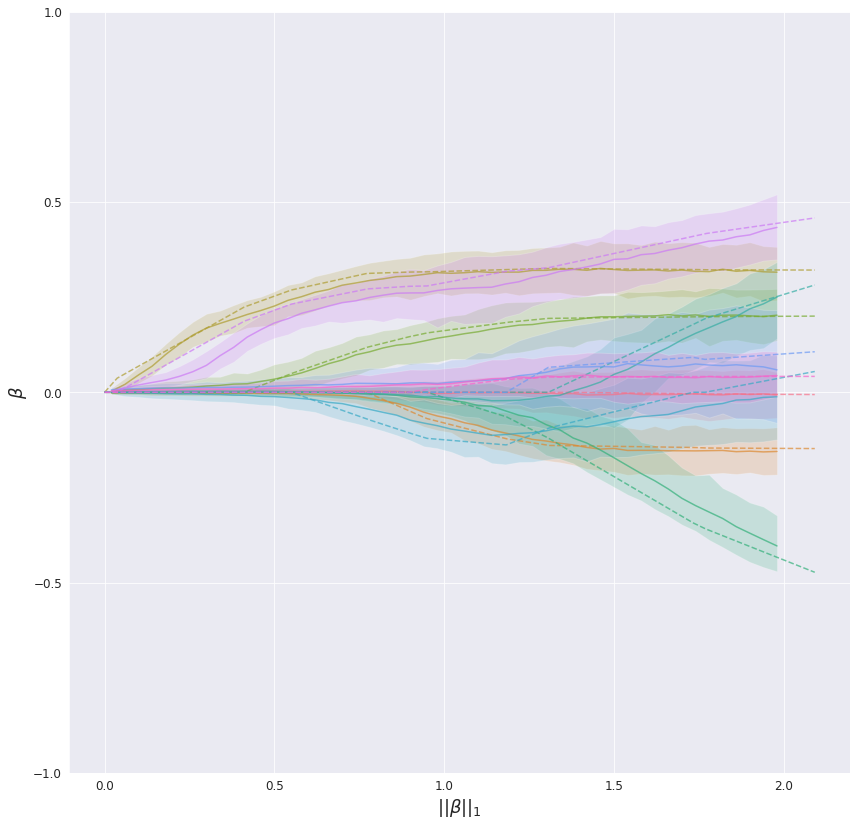

100%|██████████| 1000/1000 [00:00<00:00, 1431.73it/s]


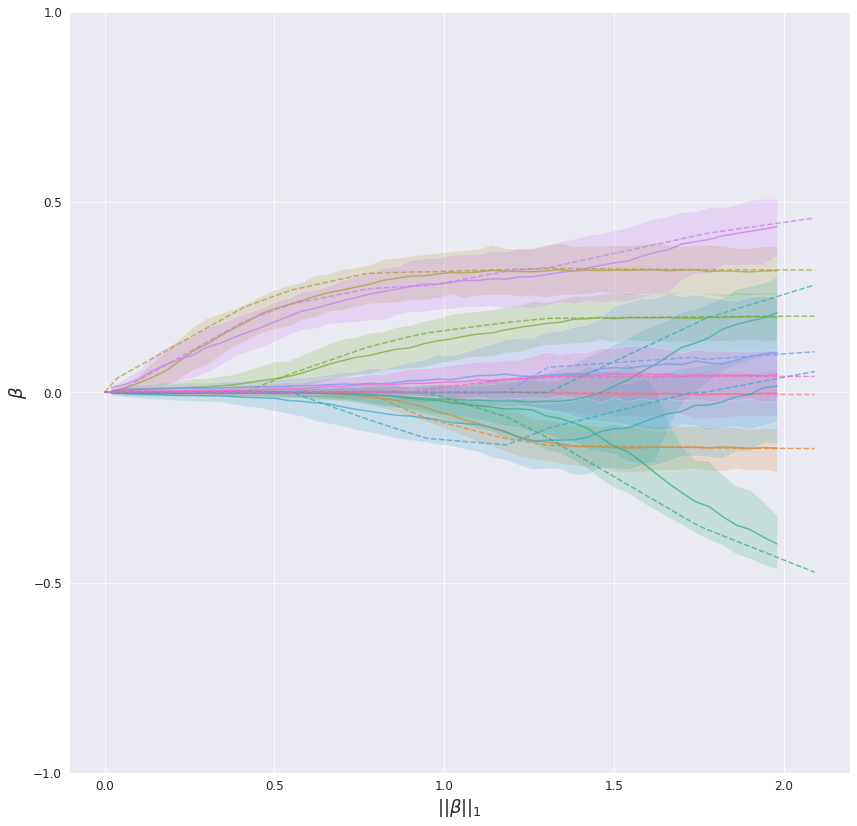

100%|██████████| 1000/1000 [00:00<00:00, 1364.69it/s]


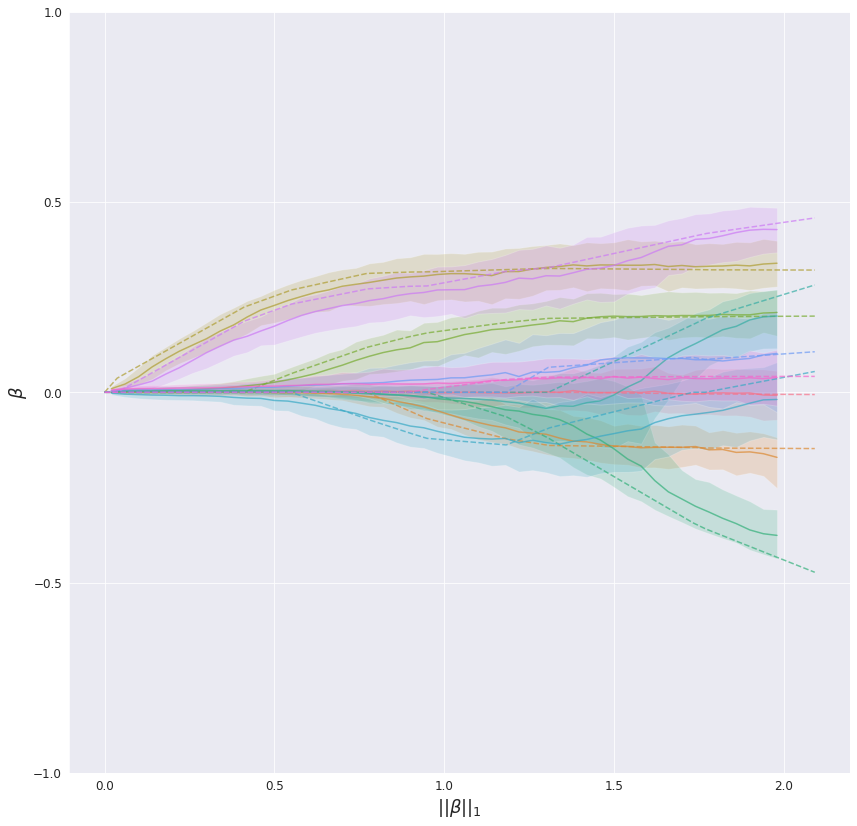

100%|██████████| 1000/1000 [00:00<00:00, 1396.30it/s]


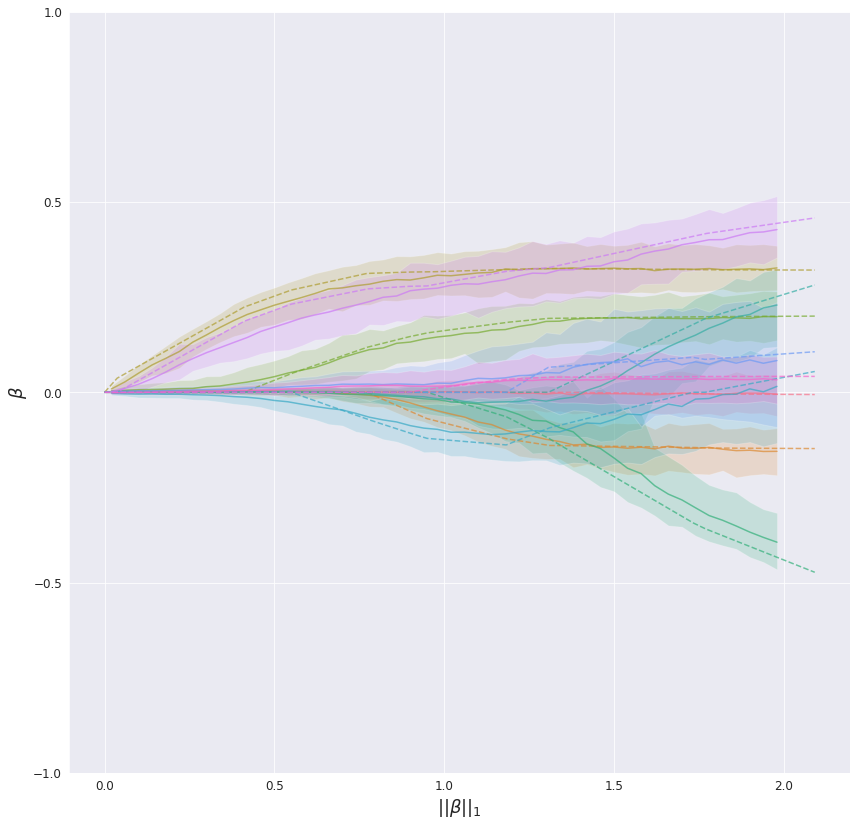

100%|██████████| 1000/1000 [00:00<00:00, 1291.95it/s]


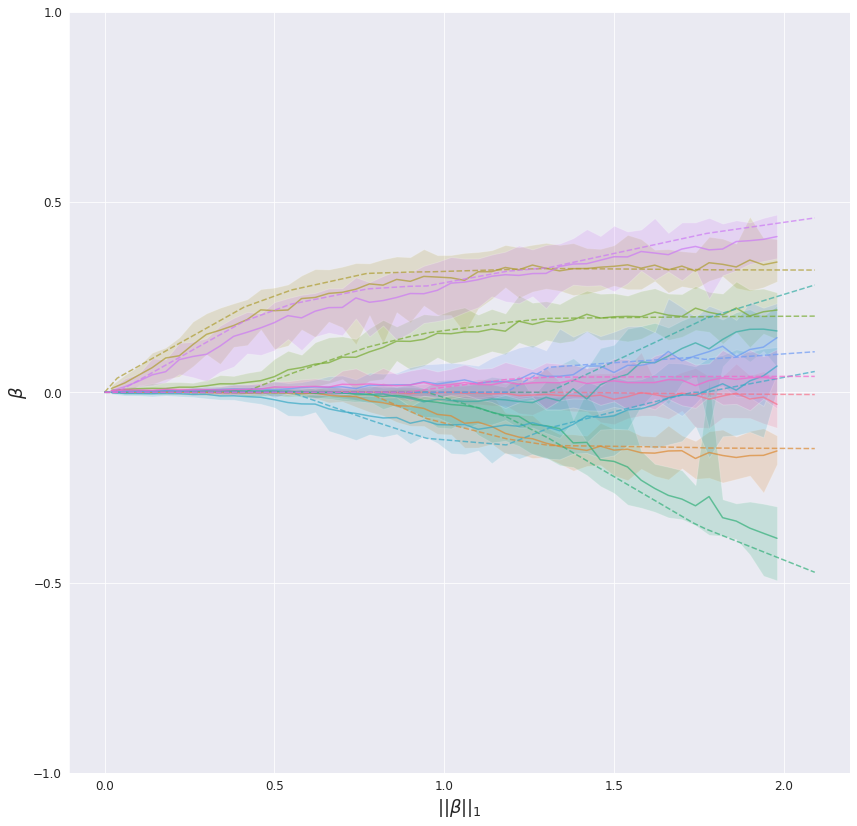

In [21]:
alphas_lasso = np.logspace(-1, 3, 100)

In [27]:
alphas_lasso = np.logspace(-1, 3, 100)
coefs, ci_l, ci_r, all_samples = [], [], [], []
conf = 0.95
for alpha in alphas_lasso:
    print("=+"*100)
    print('alpha: ', alpha)
    df_result = bayes_function(data_df, alpha=1/alpha, chain=1)
    bayes_samples = np.array(pd.DataFrame(df_result)).T
    bayes_samples = bayes_samples[:,1:-1]
    all_samples.append(bayes_samples)
    l_quant = np.quantile(bayes_samples, 1 - conf, axis=0)
    sample_mean = np.mean(bayes_samples, axis=0)
    r_quant = np.quantile(bayes_samples, conf, axis=0)
    coefs.append(sample_mean)
    ci_l.append(l_quant)
    ci_r.append(r_quant)

all_samples_raveled = np.concatenate(all_samples, 0)
all_samples = np.array(all_samples)
coefs = np.array(coefs)
ci_l = np.array(ci_l)
ci_r = np.array(ci_r)

(50, 50, 10)

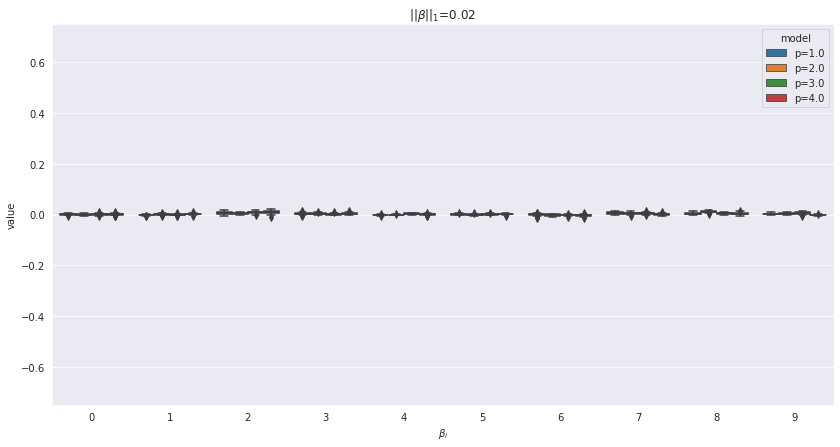

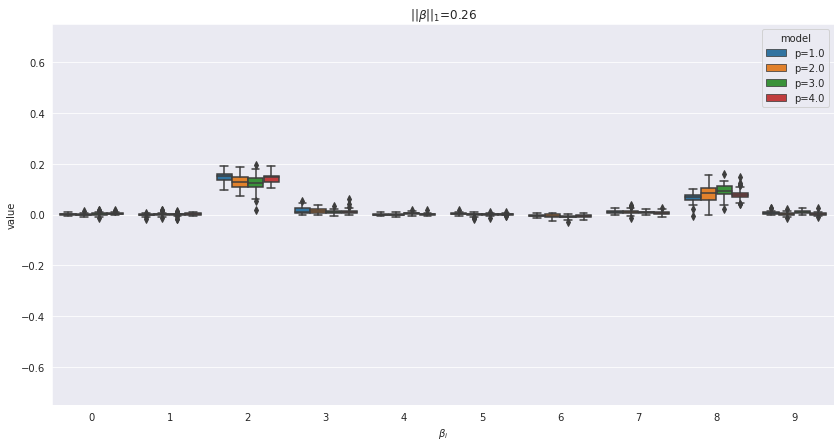

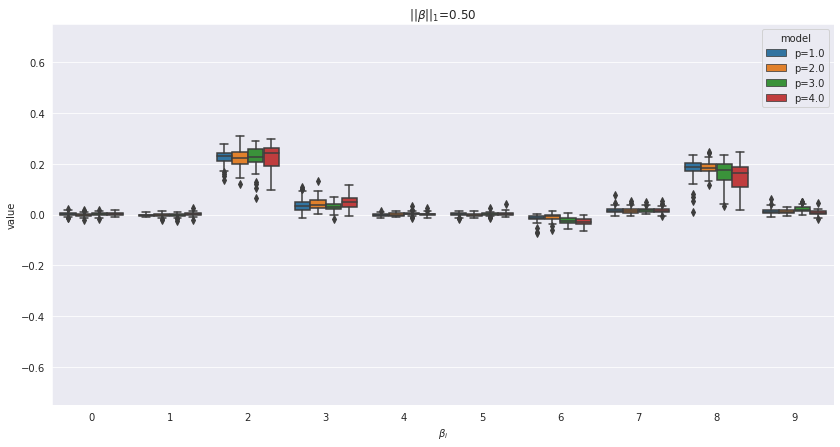

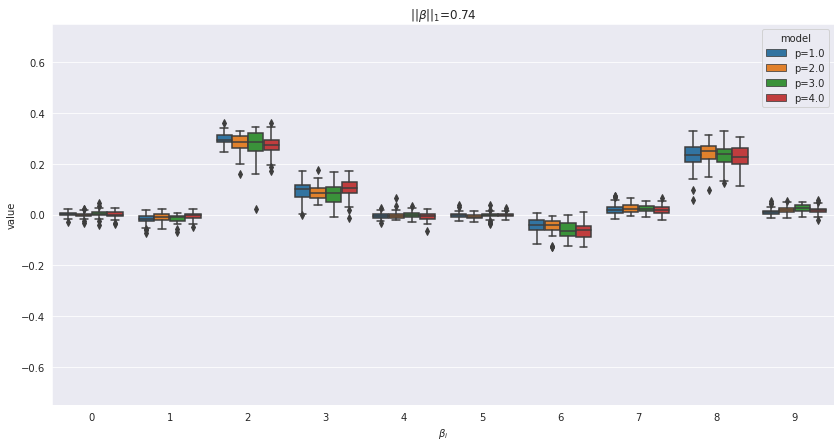

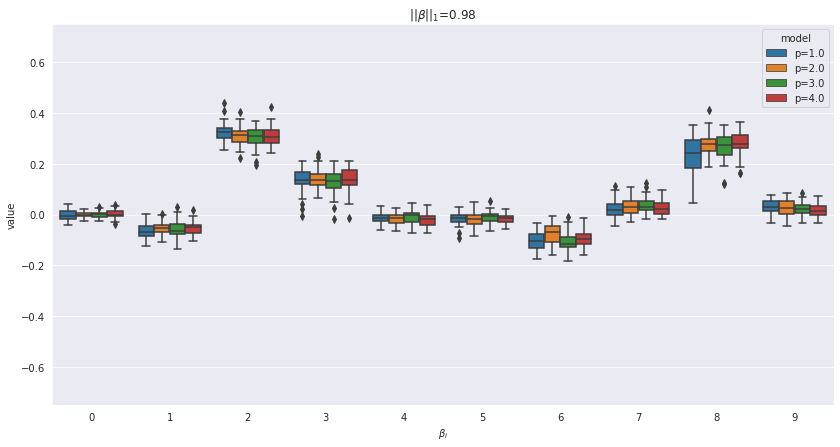

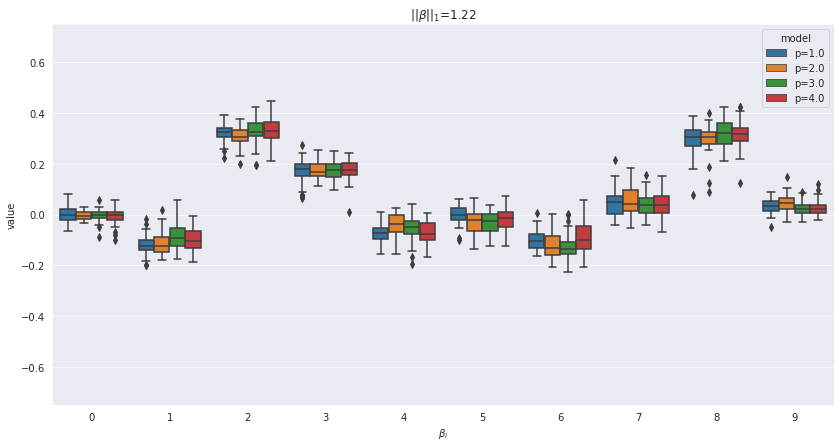

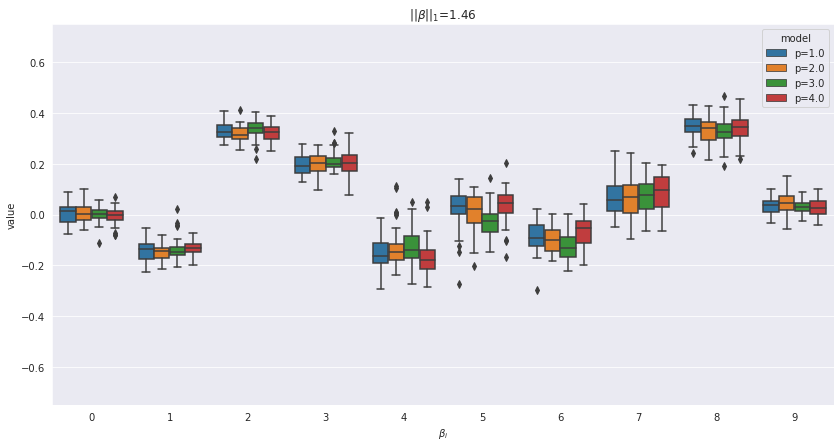

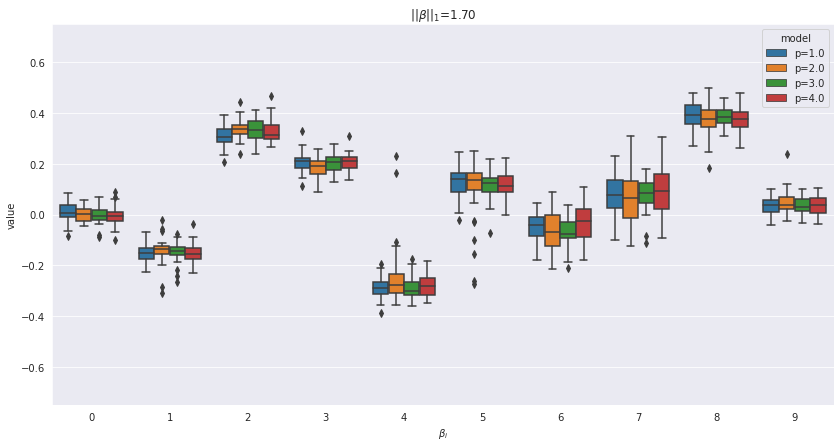

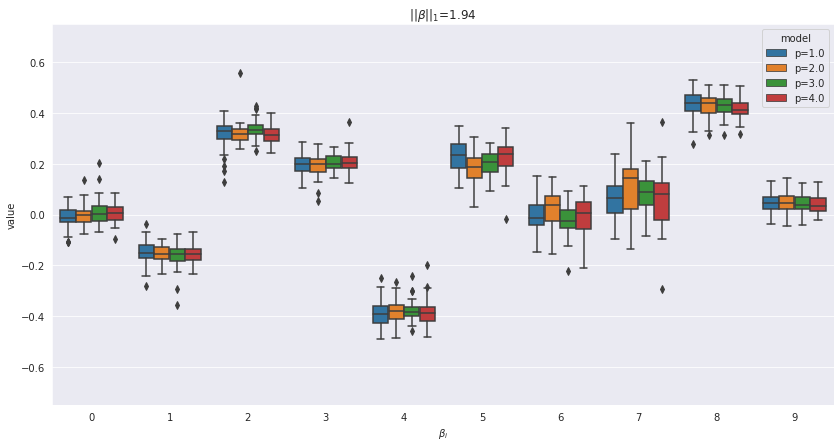

In [28]:
bins, samples_bayes, l_bayes, means_bayes, r_bayes = utils_.plot_betas_lambda(all_samples, alphas_lasso,  X_np, y_np, norm=params_flow['q'], a=0.95, folder_name=dir_name, n_plots=2)

### Bayesian linear regression comparison 
- Bayesian linear regression
- Normalizing Flow with Laplace prior and conditioned on $\lambda$
- Normalizing Flow defined on L1 manifold and conditioned on $||\beta||_1=t$

In [28]:
# sample from NF with Laplace prior
flow = utils_.build_cond_flow(flow_dim, q=q, n_layers=5, context_features=128, hidden_features=256, device=device)
flow.load_state_dict(torch.load("./models/flow_T_1"))
alphas_lasso = np.linspace(-1, 3, 10)
alphas_lasso_torch = torch.from_numpy(alphas_lasso).to(device).to(torch.float32).view(-1,1)
flow_samples, log_probs_samples = flow.sample_and_log_prob(1000, context=alphas_lasso_torch)
flow_samples_np = flow_samples.detach().cpu().numpy()
del flow_samples, log_probs_samples, flow
torch.cuda.empty_cache()
norms_flow = np.abs(flow_samples_np).sum(-1).mean(-1)

In [29]:
# sample from Bayesian Lasso 
coefs, ci_l, ci_r, norms_bayes_lasso = [], [], [], []
conf = 0.95
all_samples_bayes = {}
for alpha in 10**alphas_lasso:
    print("=+"*100)
    print('alpha: ', alpha)
    df_result = bayes_function(data_df, alpha=1/alpha, chain=1)
    bayes_samples = np.array(pd.DataFrame(df_result)).T
    bayes_samples = bayes_samples[:,1:-1]
    l_quant = np.quantile(bayes_samples, 1 - conf, axis=0)
    sample_mean = np.mean(bayes_samples, axis=0)
    r_quant = np.quantile(bayes_samples, conf, axis=0)
    sample_norm = np.abs(bayes_samples).sum(-1).mean()
    all_samples_bayes[f"{sample_norm:.4f}"] = bayes_samples
    norms_bayes_lasso.append(sample_norm)
    coefs.append(sample_mean)
    ci_l.append(l_quant)
    ci_r.append(r_quant)
    
coefs = np.array(coefs)
ci_l = np.array(ci_l)
ci_r = np.array(ci_r)
norms_bayes_lasso = np.array(norms_bayes_lasso)

=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
alpha:  0.1

SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.4e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800

In [30]:
# sample from NF on manifold
flow_manifold = utils_.build_cond_flow_manifold(flow_dim, q=q, n_layers=5, context_features=128, hidden_features=256, device=device)
flow_manifold.load_state_dict(torch.load("./models/flow_manifold_T_1"))
norms_flow_manifold = 0.5*(norms_bayes_lasso + norms_flow)
norms_flow_torch = torch.from_numpy(norms_flow_manifold).to(device).to(torch.float32).view(-1,1)
manifold_samples = []
for i in tqdm.tqdm(range(10)):
    flow_manifold_samples, log_probs_samples = flow_manifold.sample_and_log_prob(100, context=norms_flow_torch)
    manifold_samples.append(flow_manifold_samples.detach().cpu().numpy())
    del flow_manifold_samples, log_probs_samples
    torch.cuda.empty_cache()
flow_manifold_samples = np.concatenate(manifold_samples, 1)
del flow_manifold
torch.cuda.empty_cache()

100%|██████████| 10/10 [00:00<00:00, 16.21it/s]


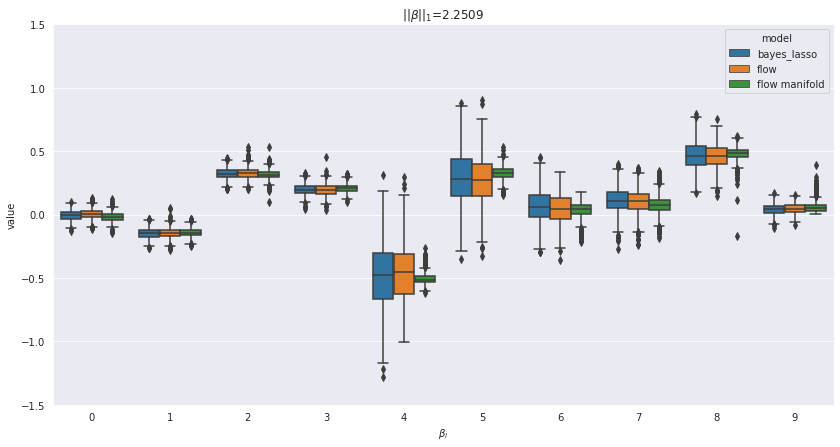

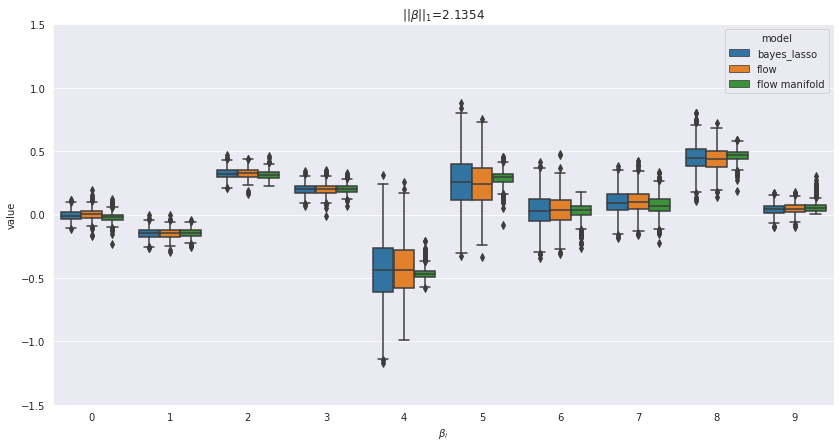

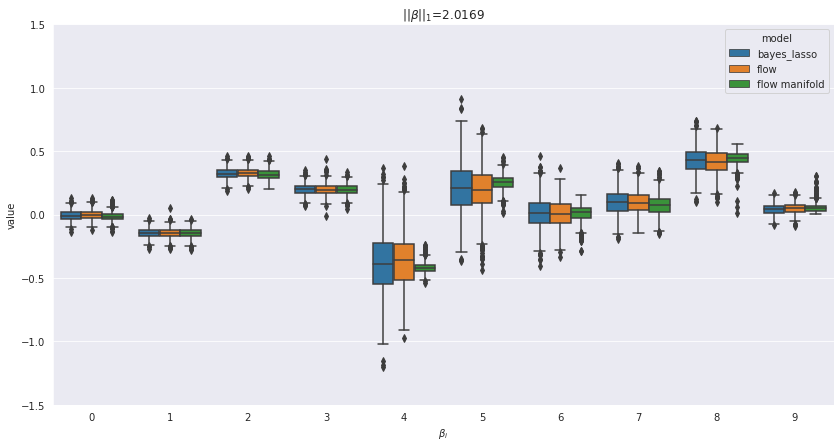

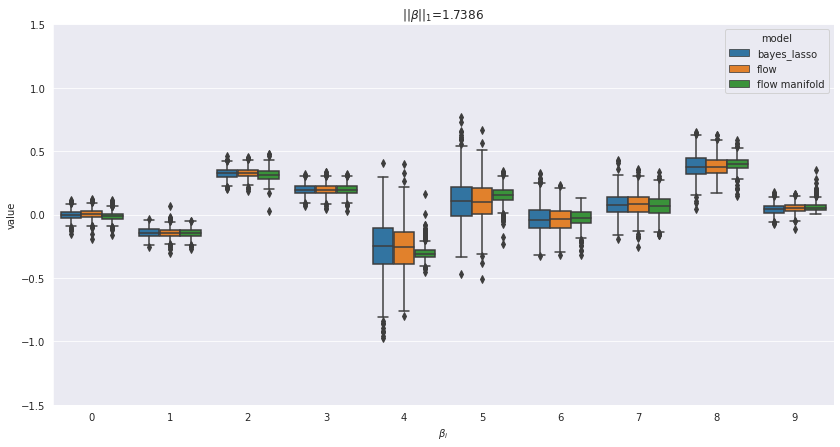

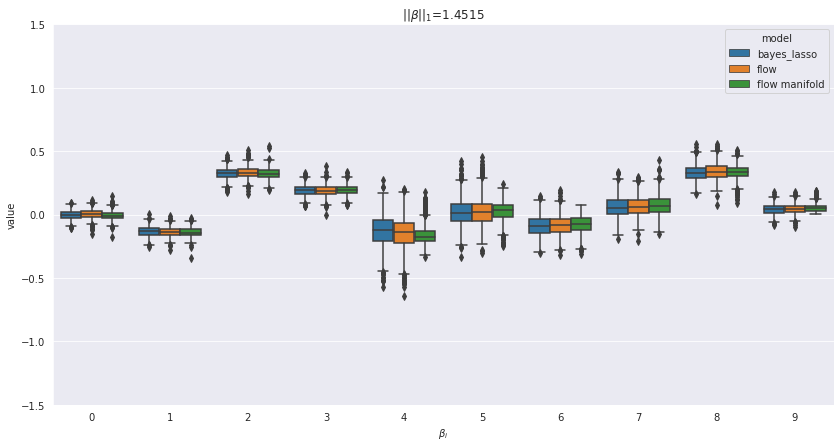

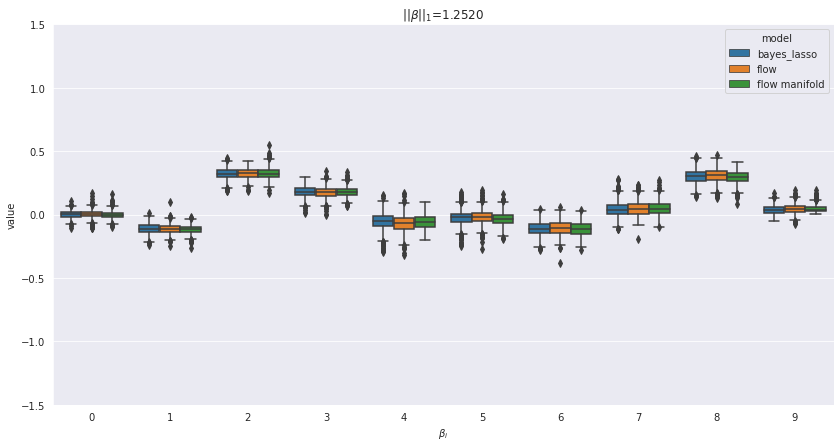

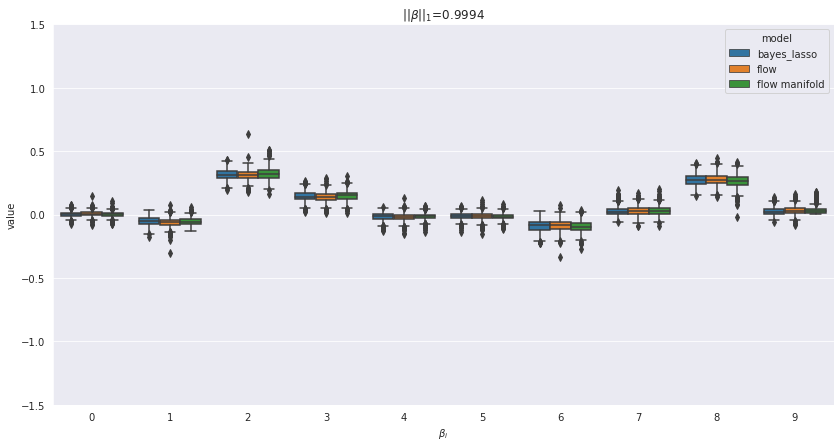

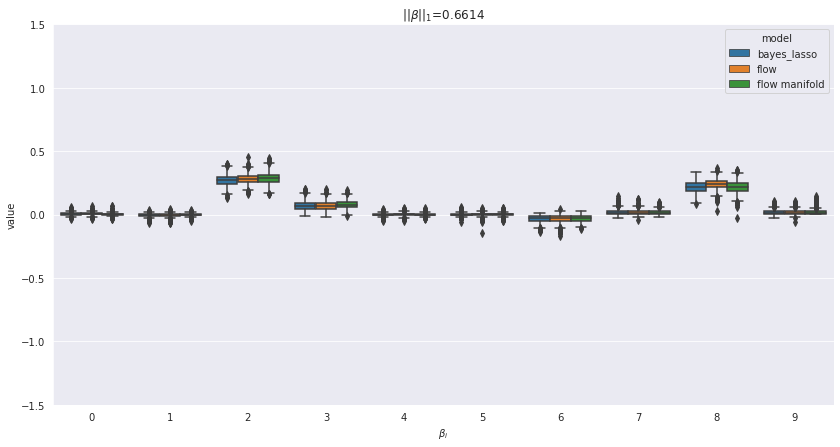

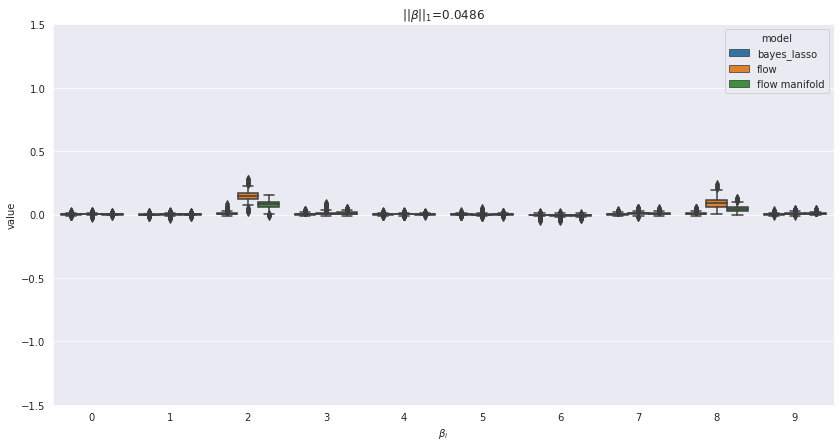

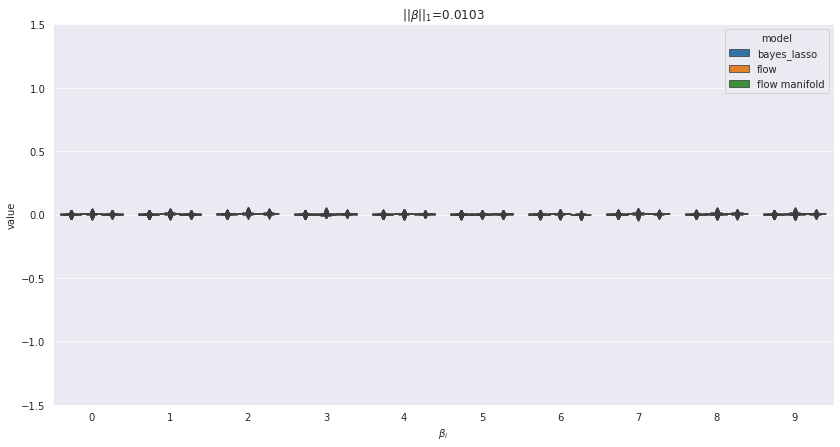

In [31]:
# plot comparison
for i, key_norm in enumerate(all_samples_bayes.keys()):
    plt.figure(figsize=(14,7))
    bayes_lasso_df = pd.DataFrame(all_samples_bayes[key_norm]).assign(model="bayes_lasso")
    flow_df = pd.DataFrame(flow_samples_np[i]).assign(model="flow")
    flow_manifold_df = pd.DataFrame(flow_manifold_samples[i]).assign(model="flow manifold")
    cdf = pd.concat([bayes_lasso_df, flow_df, flow_manifold_df])
    mdf = pd.melt(cdf, id_vars=['model'], var_name=r'$\beta_i$', value_name="value")
    sns.boxplot(x=r'$\beta_i$', y="value", hue="model", data=mdf)
    plt.title(r"$||\beta||_1$={}".format(key_norm))
    plt.ylim(-1.5,1.5)
    plt.savefig(f"./plots/box_plot_norm_lambda_{key_norm}.pdf")
    plt.show()

In [19]:
min_samples = min(samples_flow.shape[1], samples_bayes.shape[1])
bins_midpoints = 0.5 * (bins[1:]+bins[:-1])
# sample from NF on manifold
flow_manifold = utils_.build_cond_flow_manifold(flow_dim, q=q, n_layers=5, context_features=128, hidden_features=256, device=device)
flow_manifold.load_state_dict(torch.load("./models/flow_manifold_T_1"))
norms_flow_torch = torch.from_numpy(bins_midpoints).to(device).to(torch.float32).view(-1,1)
manifold_samples = []
for i in tqdm.tqdm(range(min_samples//20)):
    flow_manifold_samples, log_probs_samples = flow_manifold.sample_and_log_prob(20, context=norms_flow_torch)
    manifold_samples.append(flow_manifold_samples.detach().cpu().numpy())
    del flow_manifold_samples, log_probs_samples
    torch.cuda.empty_cache()
flow_manifold_samples = np.concatenate(manifold_samples, 1)
del flow_manifold
torch.cuda.empty_cache()

100%|██████████| 16/16 [00:01<00:00, 15.90it/s]


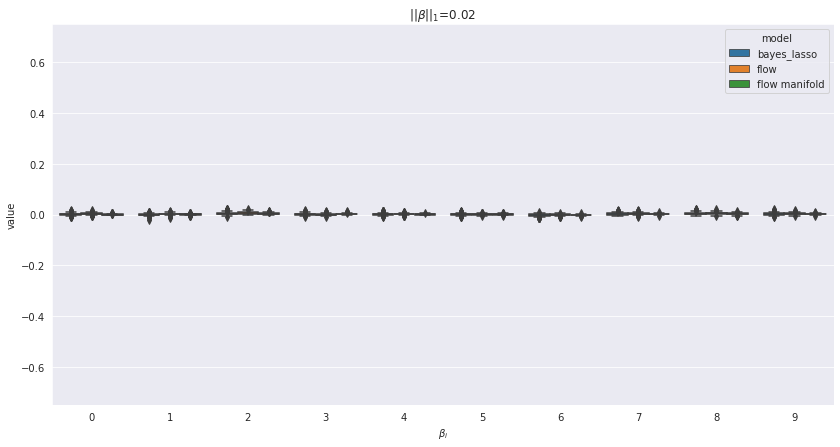

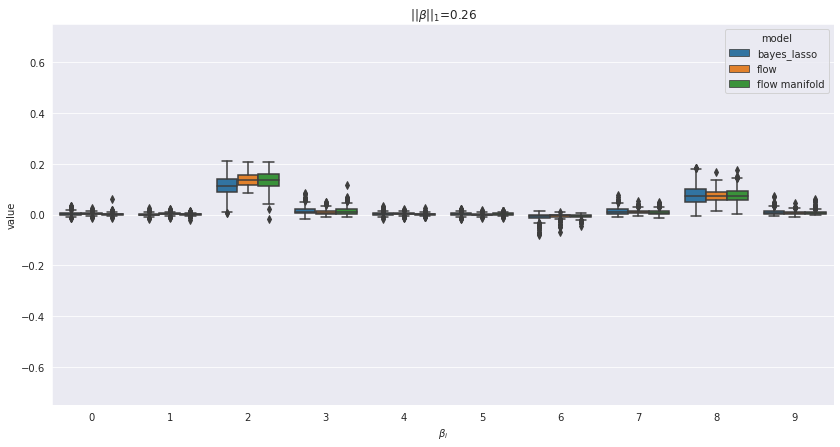

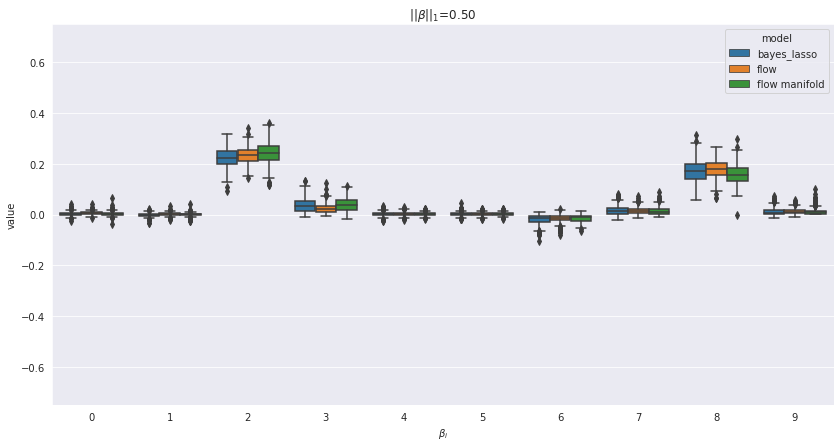

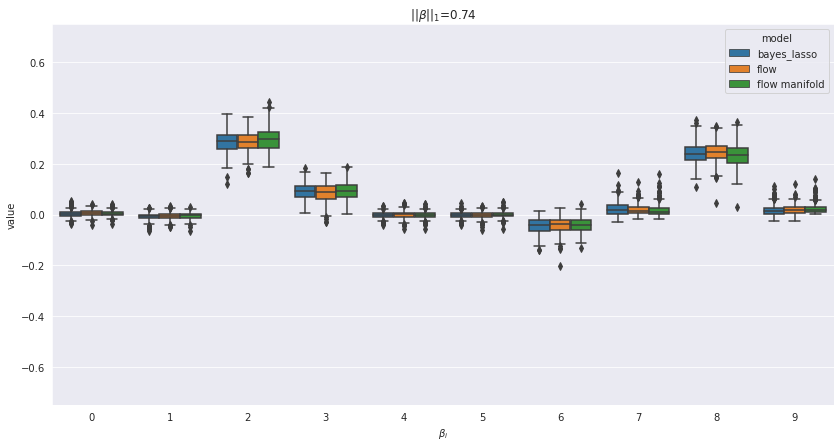

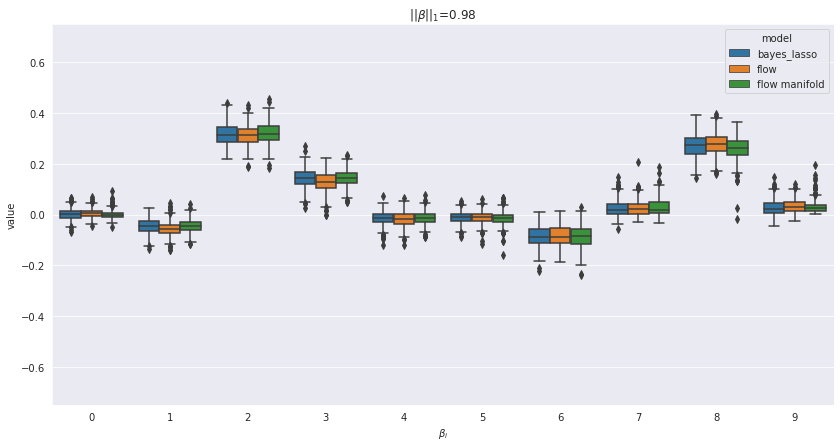

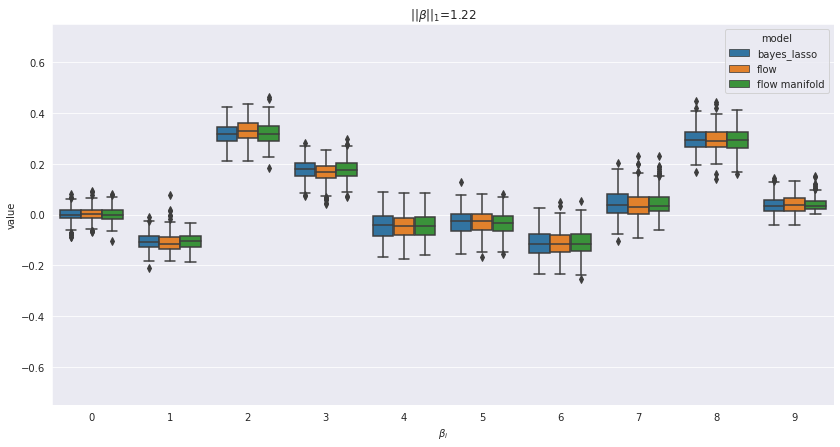

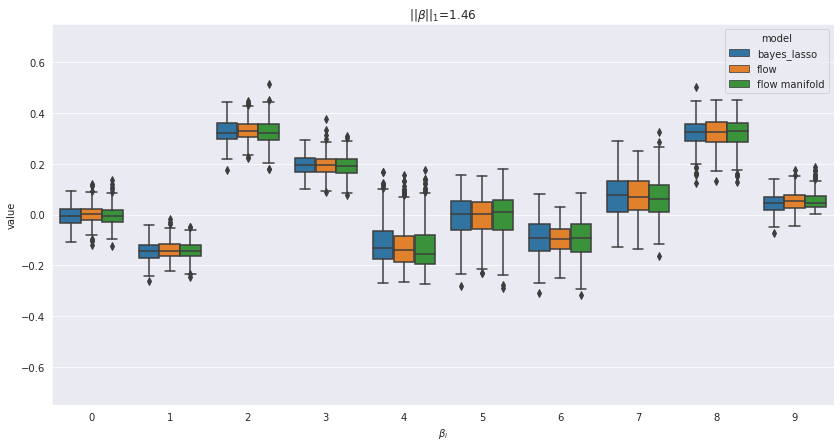

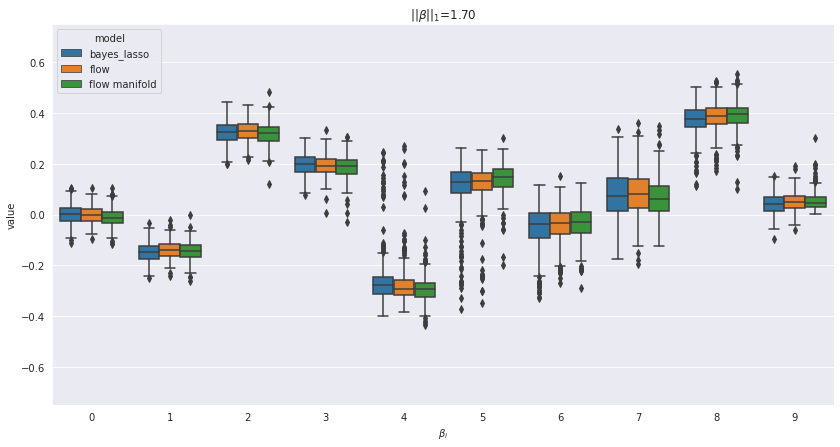

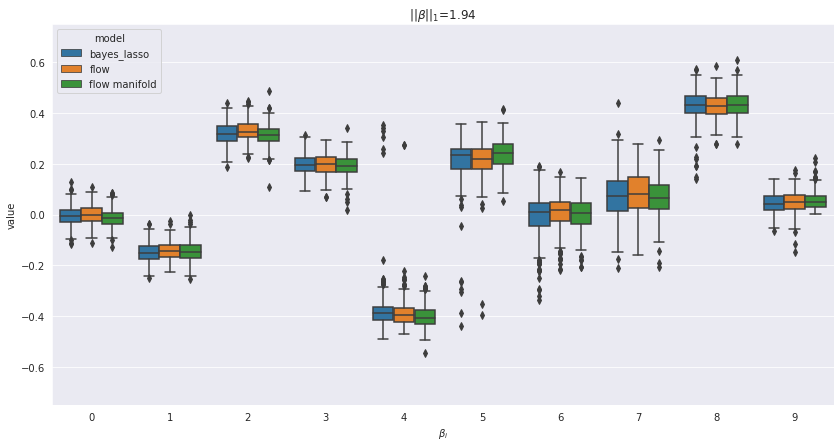

In [27]:
indeces = np.linspace(0,49,50).astype('int')[::6]

# plot comparison
for i in indeces:
    plt.figure(figsize=(14,7))
    bayes_lasso_df = pd.DataFrame(samples_bayes[i,:min_samples]).assign(model="bayes_lasso")
    flow_df = pd.DataFrame(samples_flow[i,:min_samples]).assign(model="flow")
    flow_manifold_df = pd.DataFrame(flow_manifold_samples[i]).assign(model="flow manifold")
    cdf = pd.concat([bayes_lasso_df, flow_df, flow_manifold_df])
    mdf = pd.melt(cdf, id_vars=['model'], var_name=r'$\beta_i$', value_name="value")
    sns.boxplot(x=r'$\beta_i$', y="value", hue="model", data=mdf)
    # sns.violinplot(x=r'$\beta_i$', y="value", hue="model", data=mdf)
    plt.title(r"$||\beta||_1$={:.2f}".format(bins_midpoints[i]))
    plt.ylim(-0.75,0.75)
    plt.savefig(f"./plots/box_plot_norm_{bins_midpoints[i]:.2f}.pdf")
    plt.show()